In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
!nvidia-smi

Tue Jan 17 09:06:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install ultralytics -q

from IPython import display
display.clear_output()
!yolo mode=checks

Ultralytics YOLOv8.0.6 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.0/166.8 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

In [9]:
!rm -r /content/kaggle-ships-in-google-earth-3
# !rm -r /content/datasets/runs

Note there is a recent change in YOLOv8 requiring datasets in a `datasets` - not sure if this will change

In [10]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
from getpass import getpass

api_key = getpass('Enter ROBOFLOW_API_KEY secret value: ')

rf = Roboflow(api_key=api_key)
project = rf.workspace("robin-public").project("kaggle-ships-in-google-earth-dfqwt")
dataset = project.version(3).download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to kaggle-ships-in-google-earth-3 in yolov8:: 100%|██████████| 3328/3328 [00:01<00:00, 2858.85it/s]


In [11]:
print(dataset.location)
os.path.exists(f'{dataset.location}/data.yaml')

/content/datasets/kaggle-ships-in-google-earth-3


True

## Custom Training

In [7]:
# Python API is work in progress
# model = YOLO('yolov8m.pt')  # load a pretrained model (recommended for training)

# # Use the model
# results = model.train(
#     data=f'{dataset.location}/data.yaml', 
#     epochs=100,
#     imgsz=640,
#     batch=16
# )  # train the model

In [12]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 batch=16

/content
Ultralytics YOLOv8.0.6 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/kaggle-ships-in-google-earth-3/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=

In [13]:
!ls {HOME}/runs/detect/train2/

args.yaml					    train_batch2.jpg
confusion_matrix.png				    train_batch8010.jpg
events.out.tfevents.1673947179.d462a08e4291.5450.0  train_batch8011.jpg
F1_curve.png					    train_batch8012.jpg
P_curve.png					    val_batch0_labels.jpg
PR_curve.png					    val_batch0_pred.jpg
predictions.json				    val_batch1_labels.jpg
R_curve.png					    val_batch1_pred.jpg
results.csv					    val_batch2_labels.jpg
results.png					    val_batch2_pred.jpg
train_batch0.jpg				    weights
train_batch1.jpg


/content


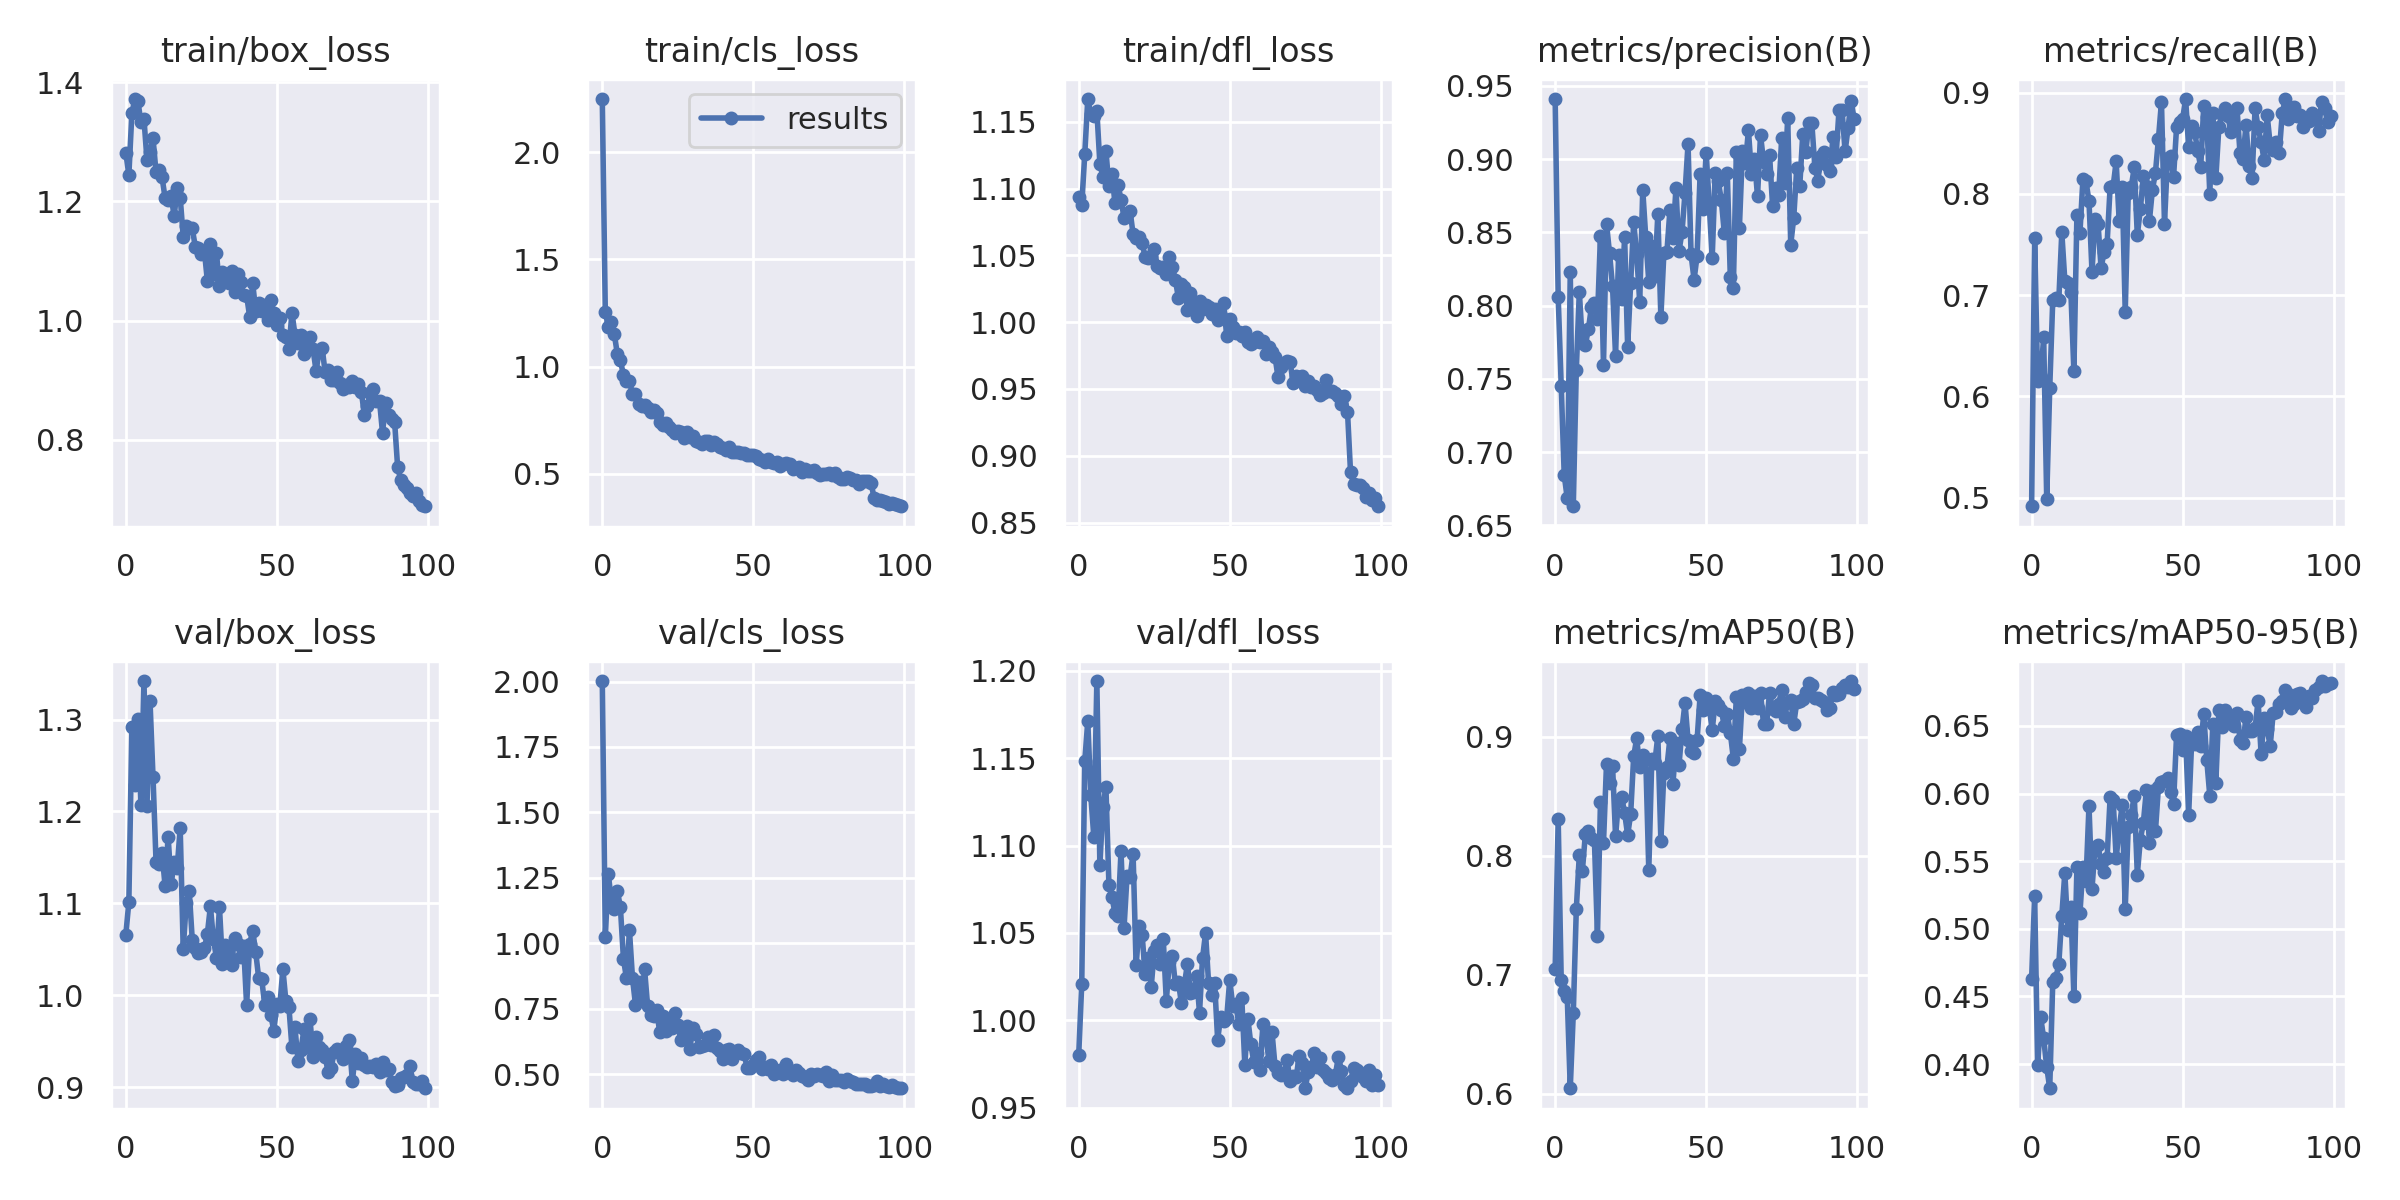

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000) # apparently not created using the python api

/content


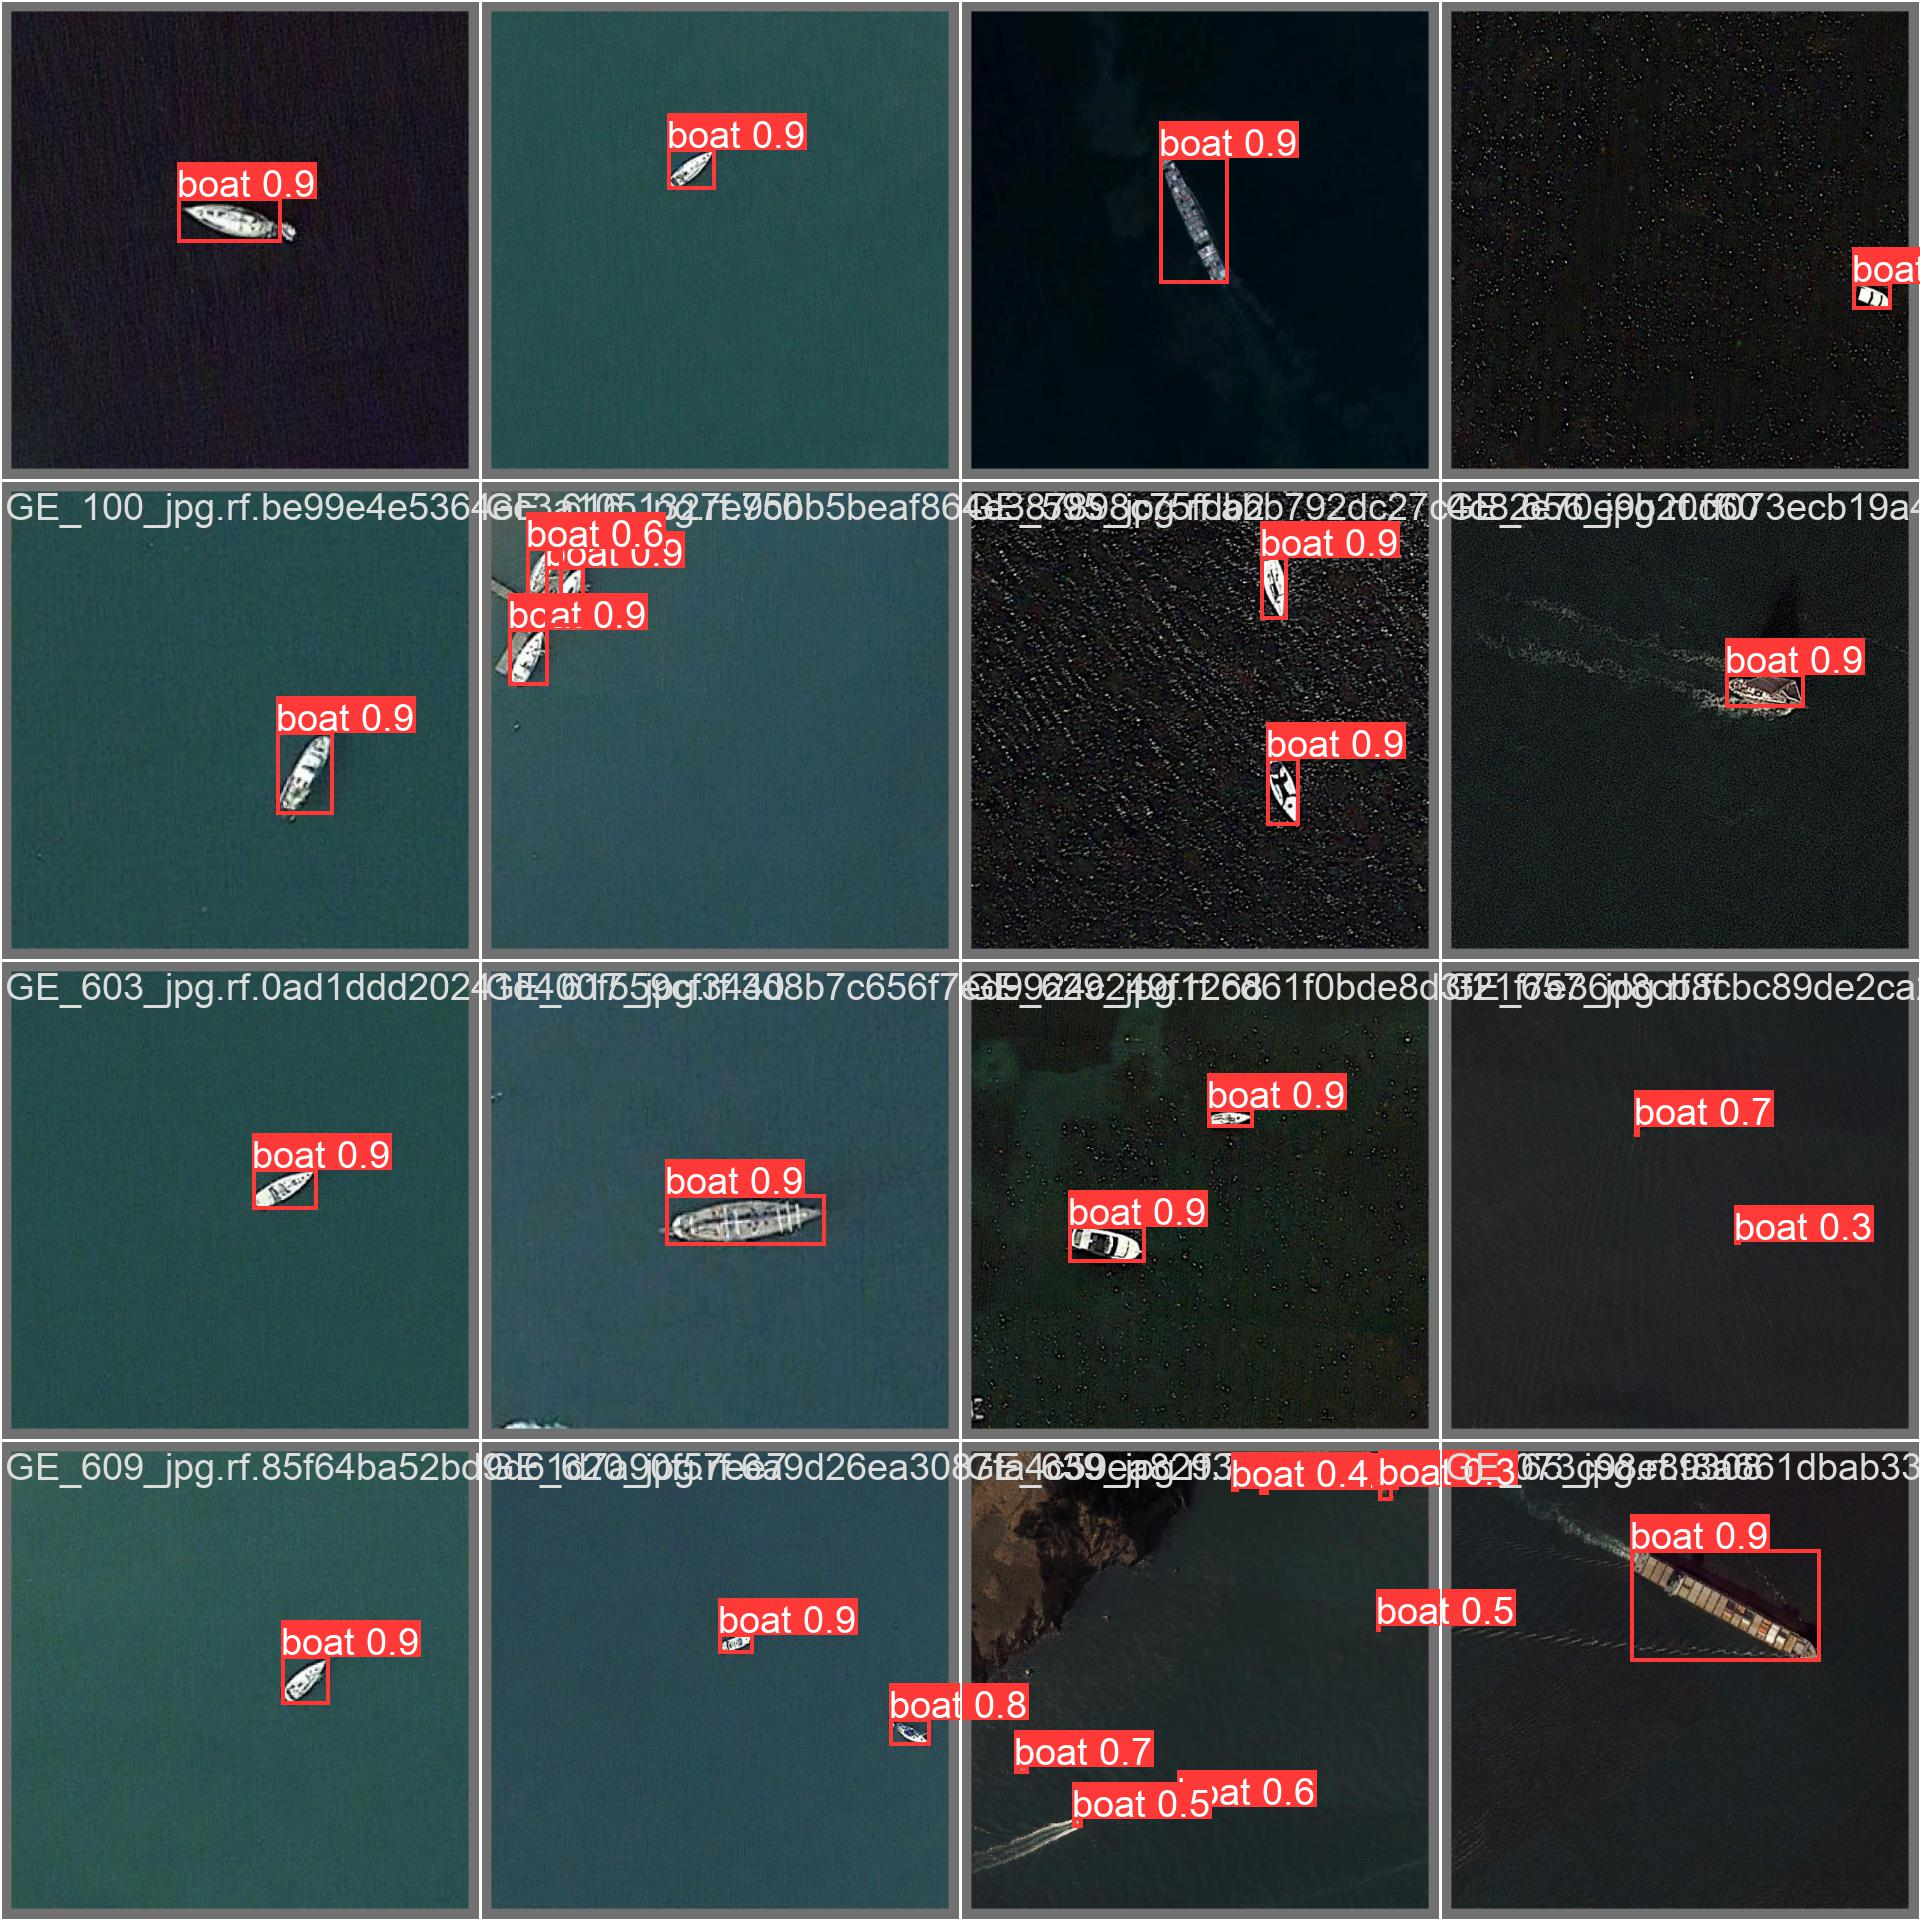

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [16]:
# results = model.val()

In [17]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.6 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
Model summary: 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/kaggle-ships-in-google-earth-3/valid/labels.cache... 159 images, 0 backgrounds, 0 corrupt: 100% 159/159 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 10/10 [00:03<00:00,  2.77it/s]
                   all        159        357      0.919      0.863      0.941      0.683
Speed: 2.2ms pre-process, 5.4ms inference, 0.0ms loss, 1.9ms post-process per image


## Inference with Custom Model

In [18]:
# model.predict(conf=0.7, source=f"{dataset.location}/test/images", save=True)

In [19]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.7 source={dataset.location}/test/images

/content
Ultralytics YOLOv8.0.6 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
Model summary: 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
image 1/79 /content/datasets/kaggle-ships-in-google-earth-3/test/images/GE_120_jpg.rf.e7c3cded9f39881166c69c36f0aa97ae.jpg: 640x640 1 boat, 7.9ms
image 2/79 /content/datasets/kaggle-ships-in-google-earth-3/test/images/GE_138_jpg.rf.53840c0f1bb23656c231d1e566eb31bb.jpg: 640x640 3 boats, 9.0ms
image 3/79 /content/datasets/kaggle-ships-in-google-earth-3/test/images/GE_149_jpg.rf.64eaebc9c2cebd503817230290d16d29.jpg: 640x640 1 boat, 7.9ms
image 4/79 /content/datasets/kaggle-ships-in-google-earth-3/test/images/GE_163_jpg.rf.80246d857e976d499157eb5038d760e2.jpg: 640x640 1 boat, 7.9ms
image 5/79 /content/datasets/kaggle-ships-in-google-earth-3/test/images/GE_167_jpg.rf.d2f3415ed10c3a60c05816aaaf212f6f.jpg: 640x640 1 boat, 7.9ms
image 6/79 /content/datasets/kaggle-ships-in-google-earth-3/test/images/GE_188_jpg.rf

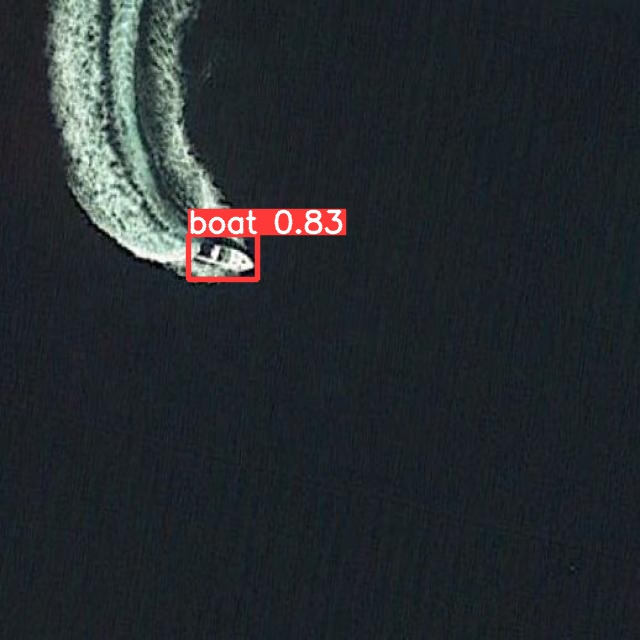

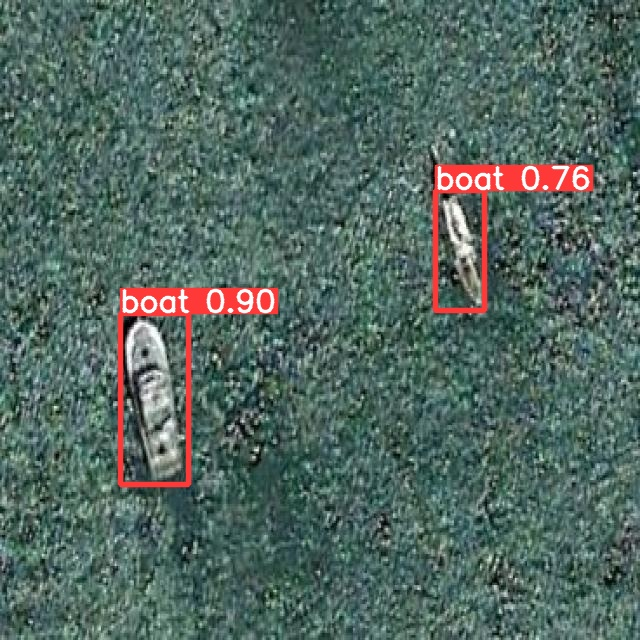

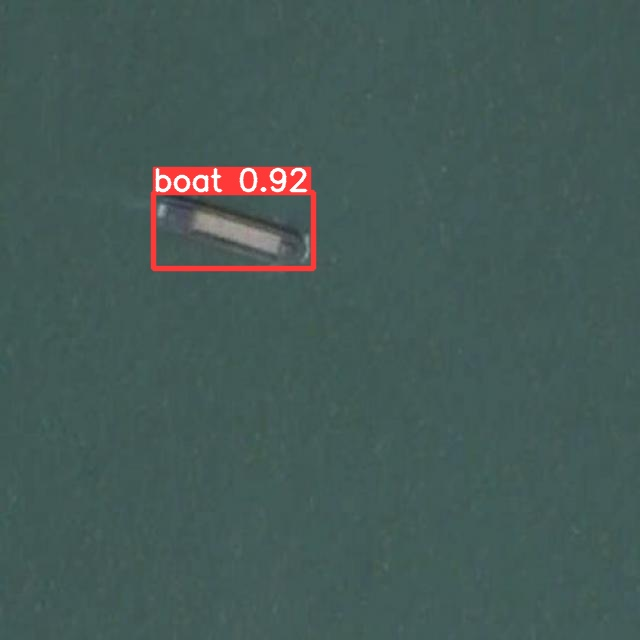

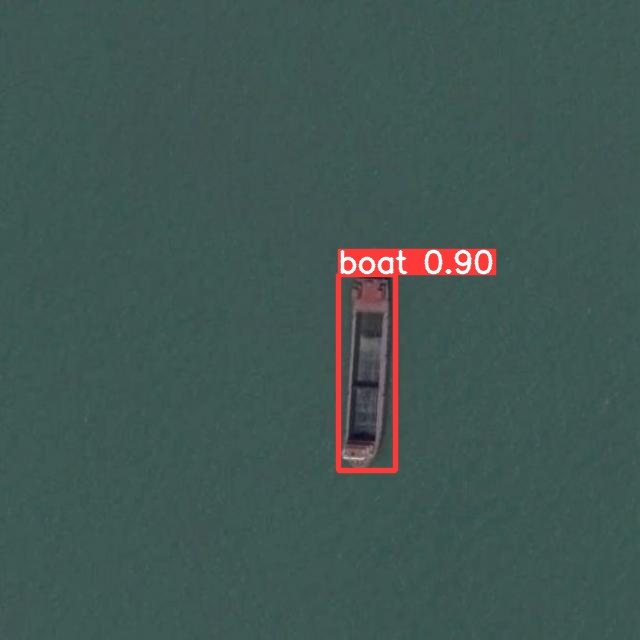

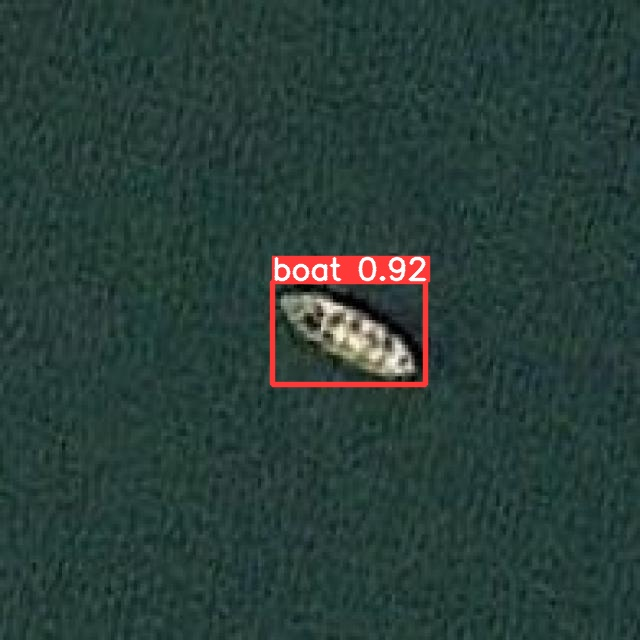

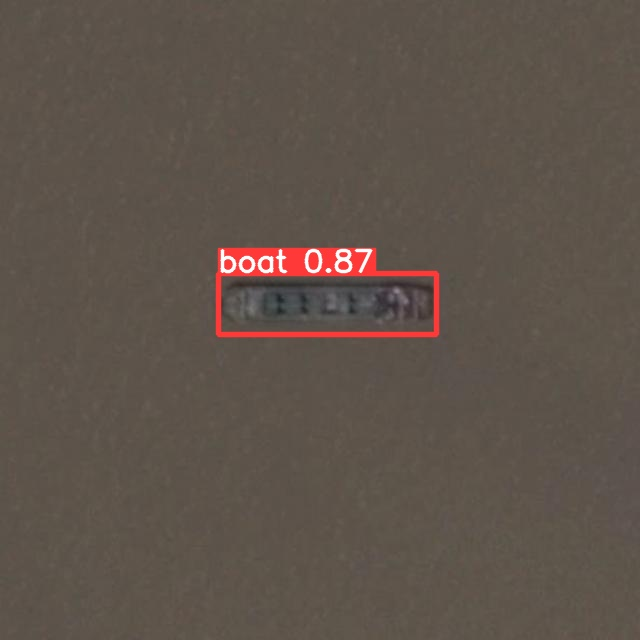

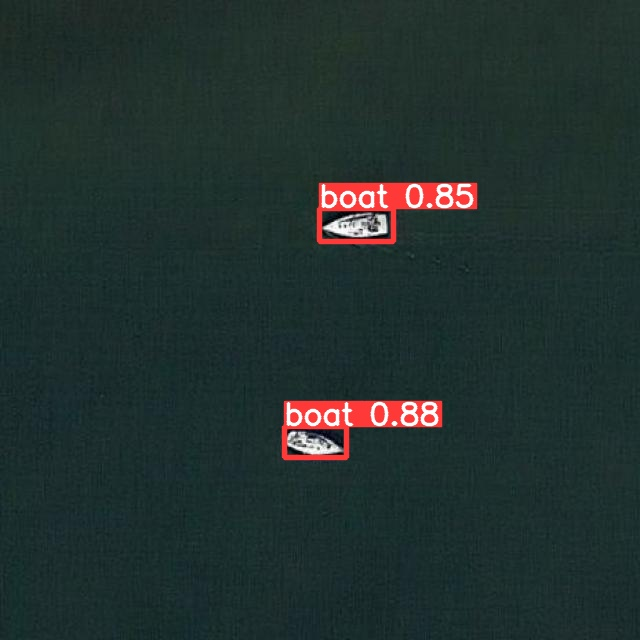

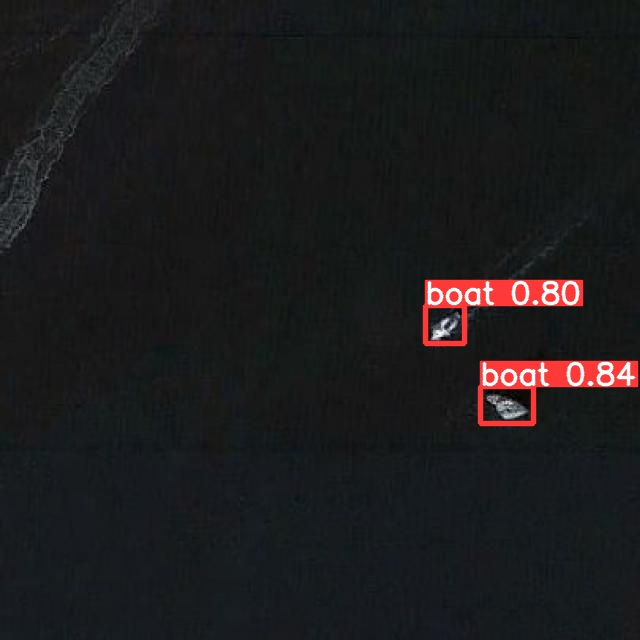

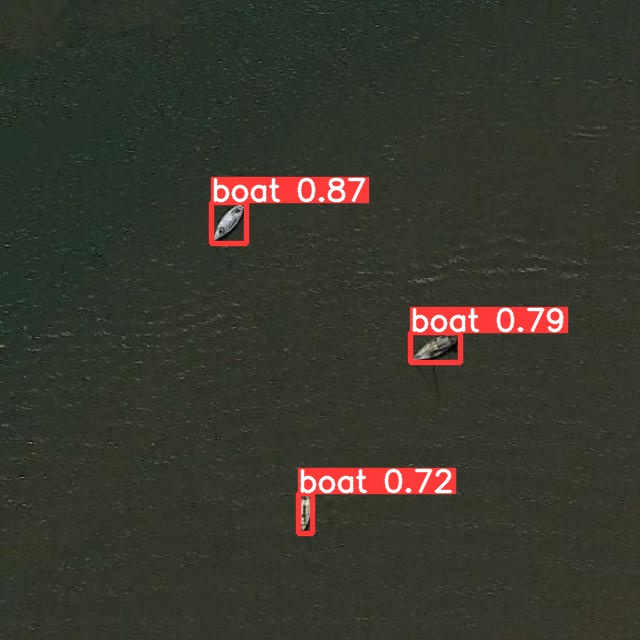

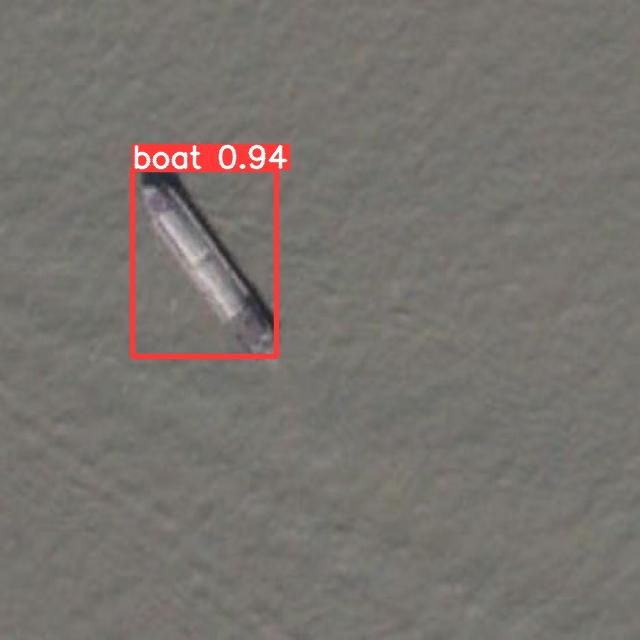

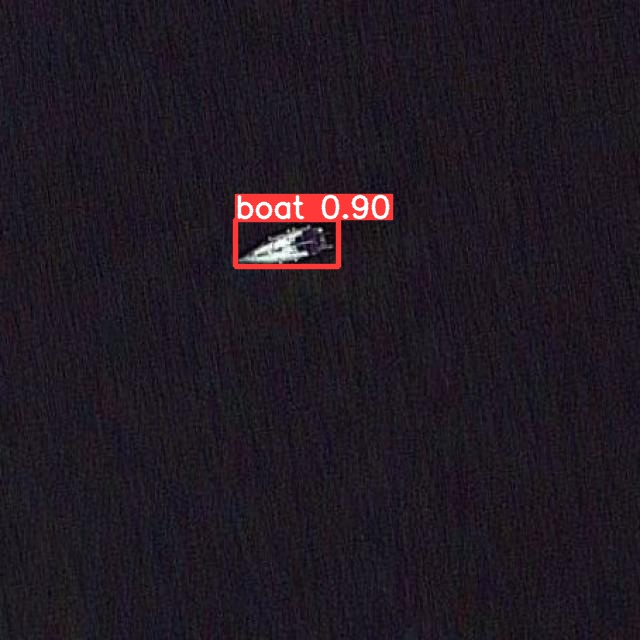

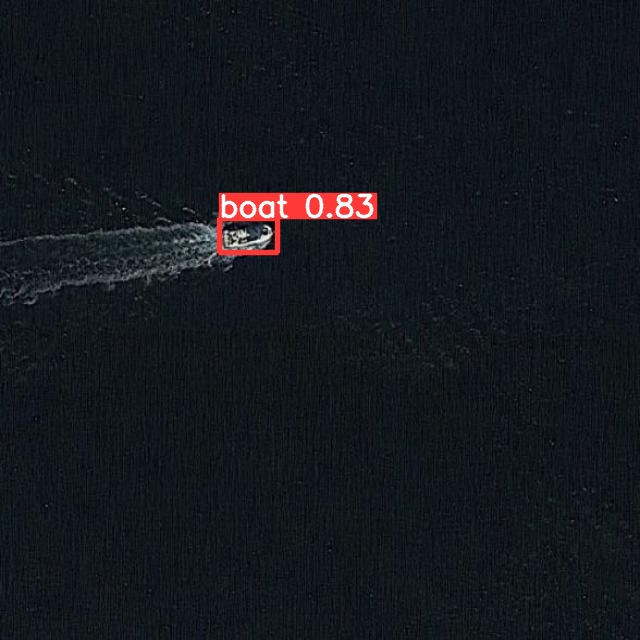

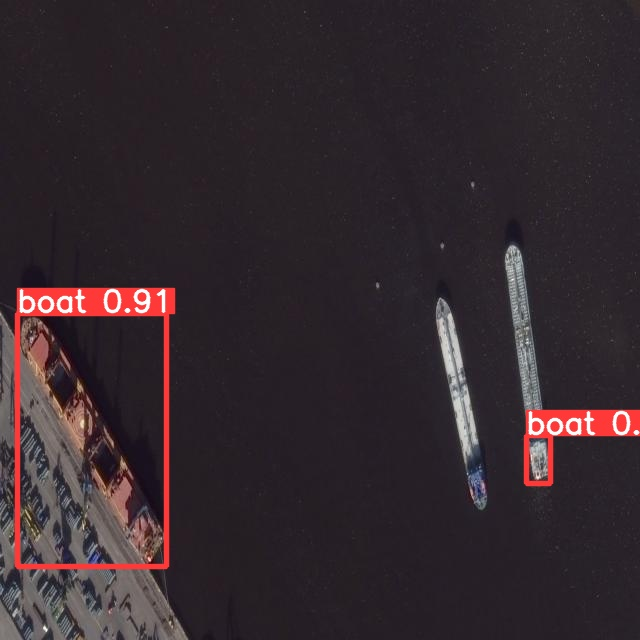

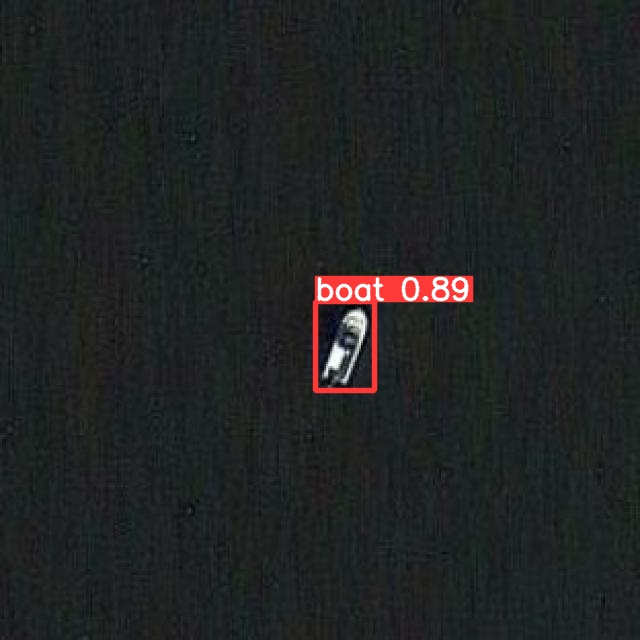

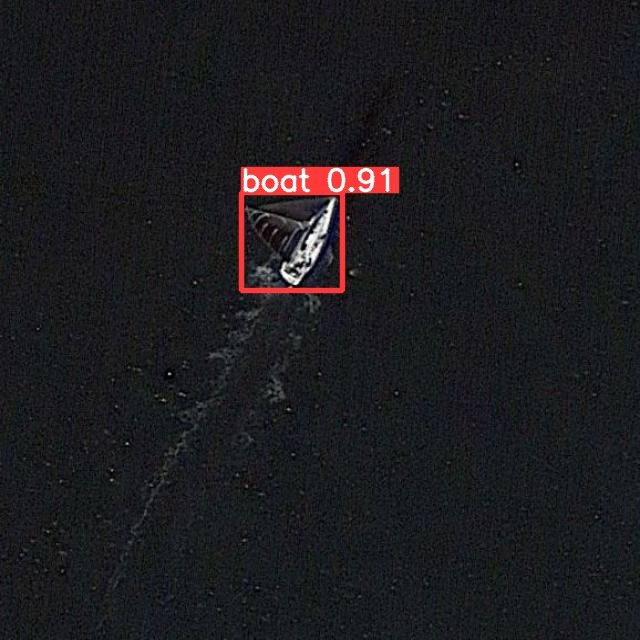

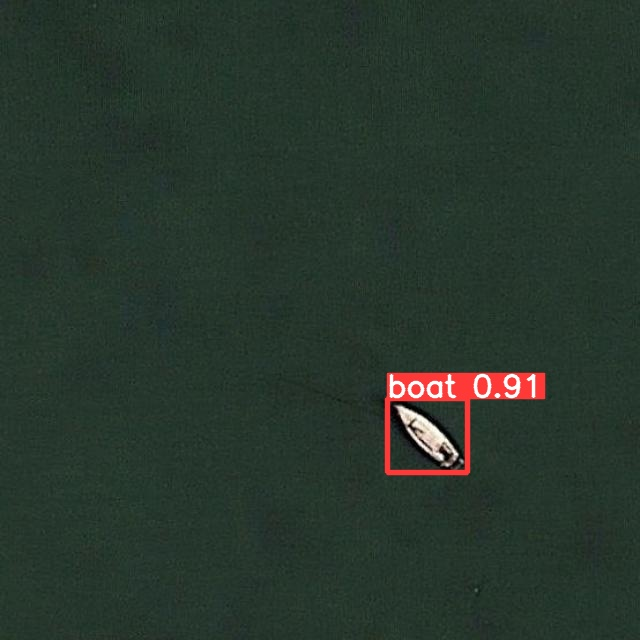

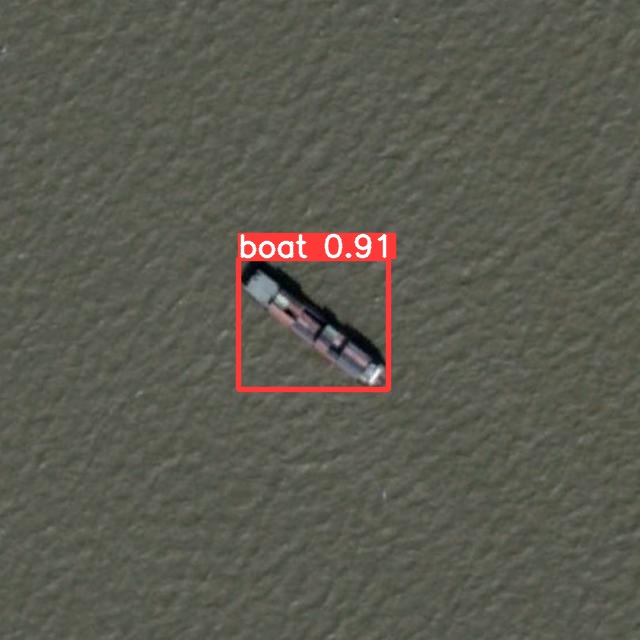

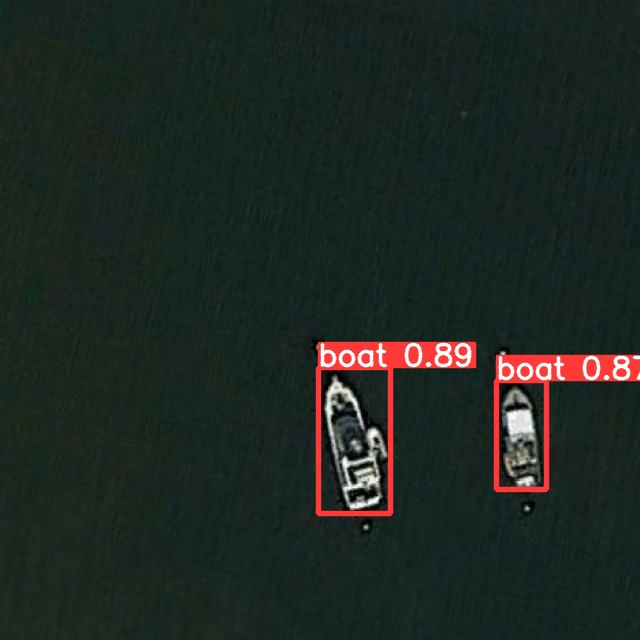

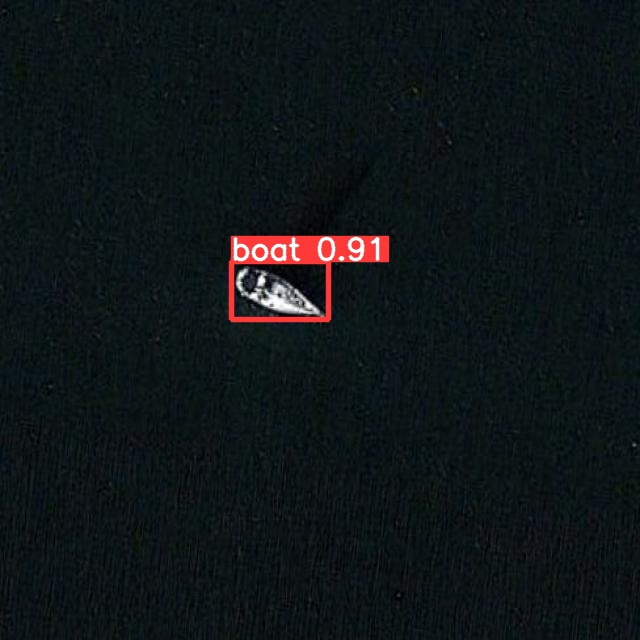

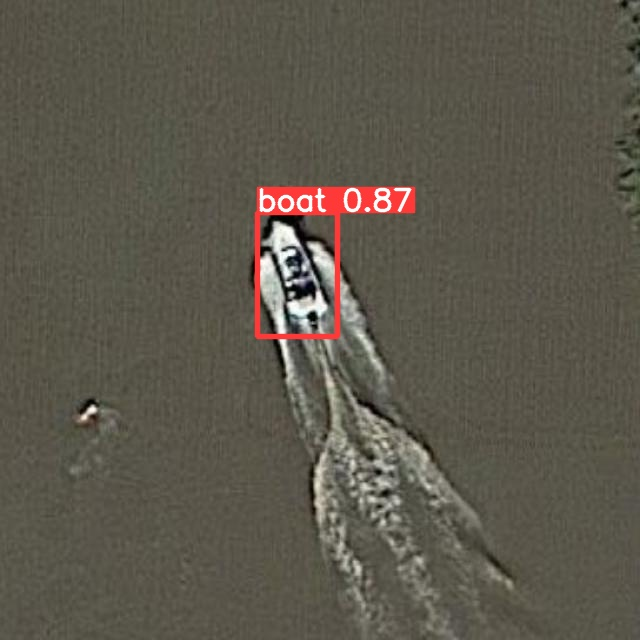

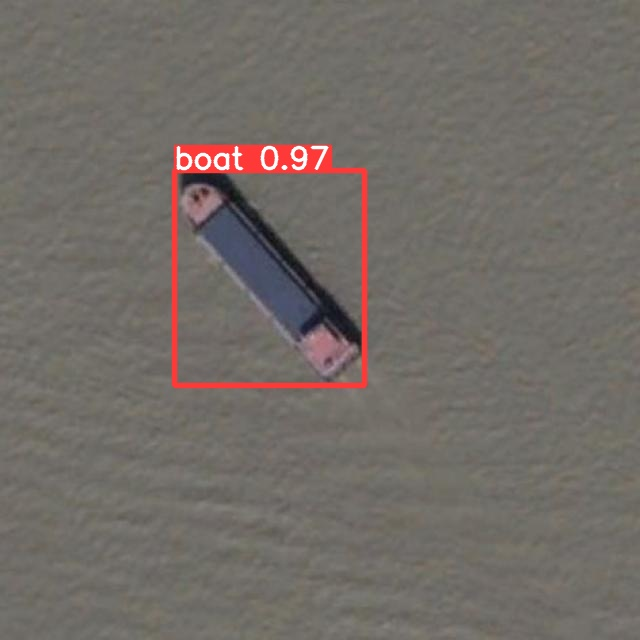

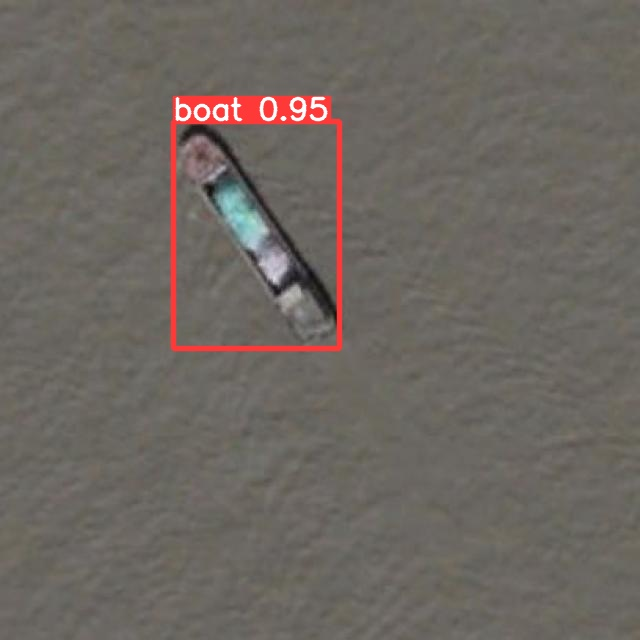

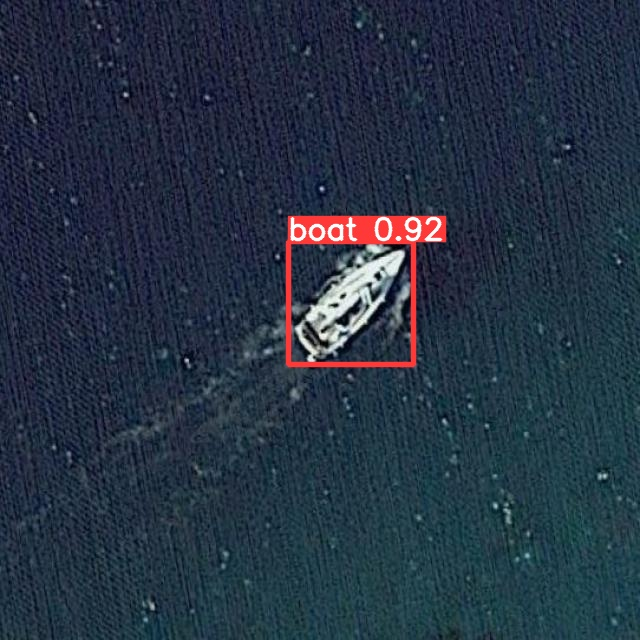

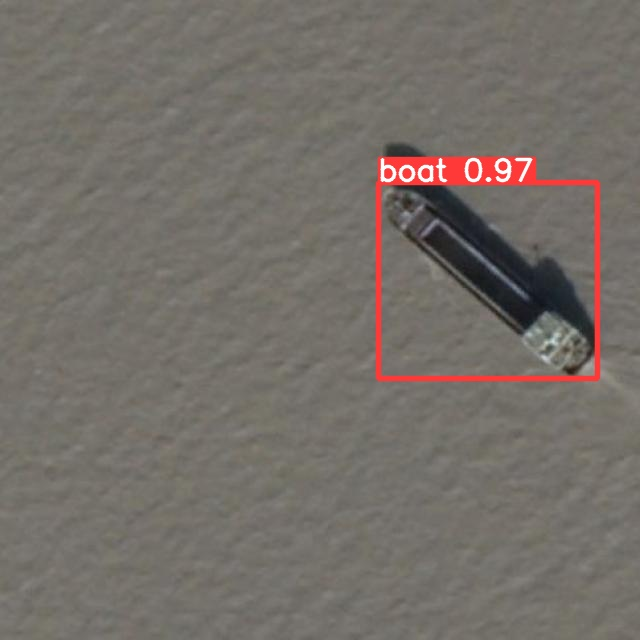

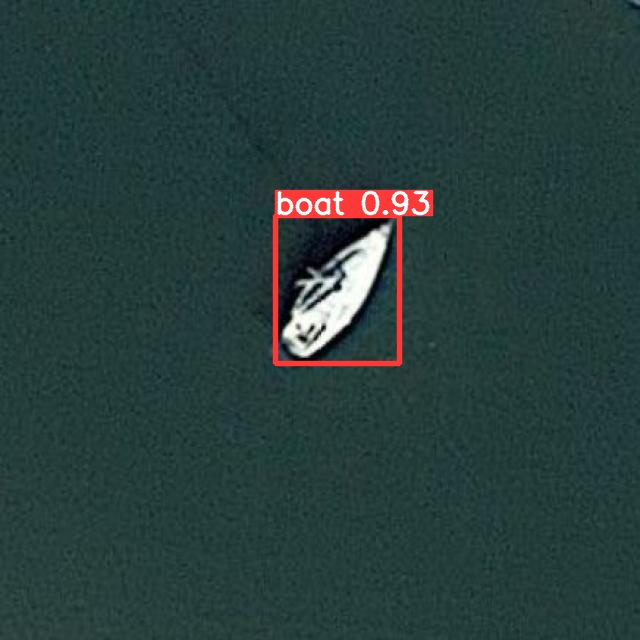

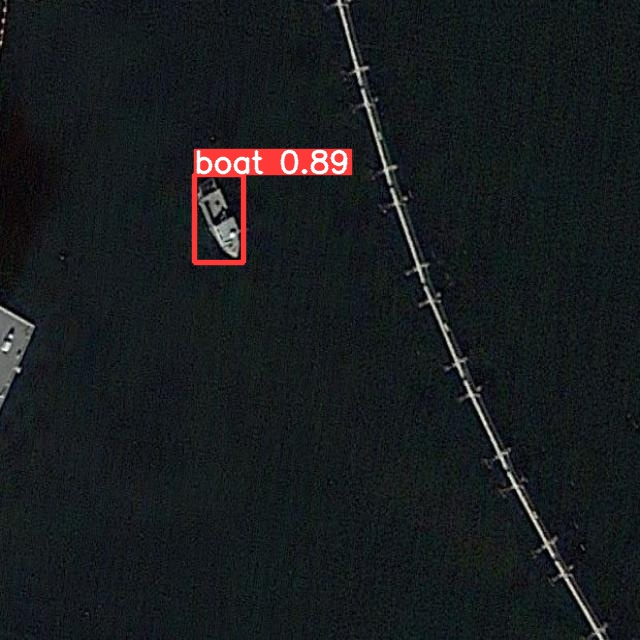

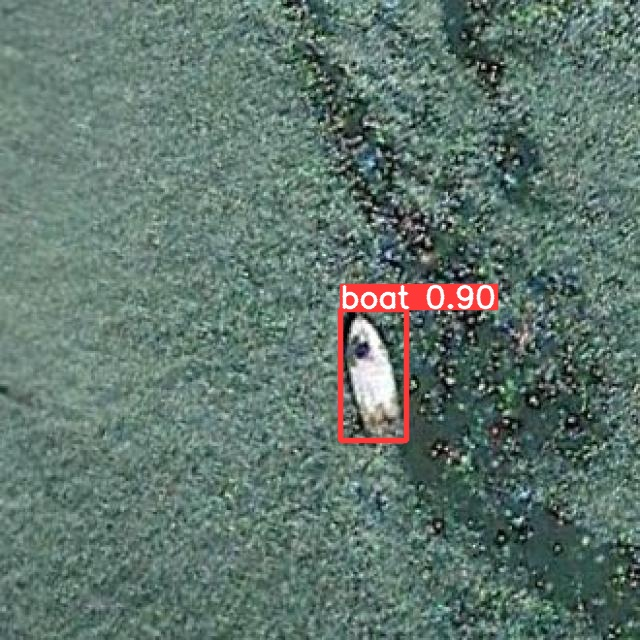

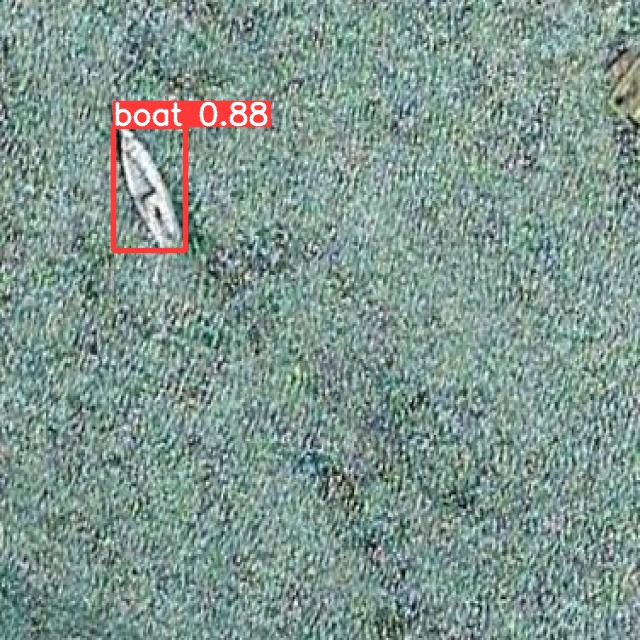

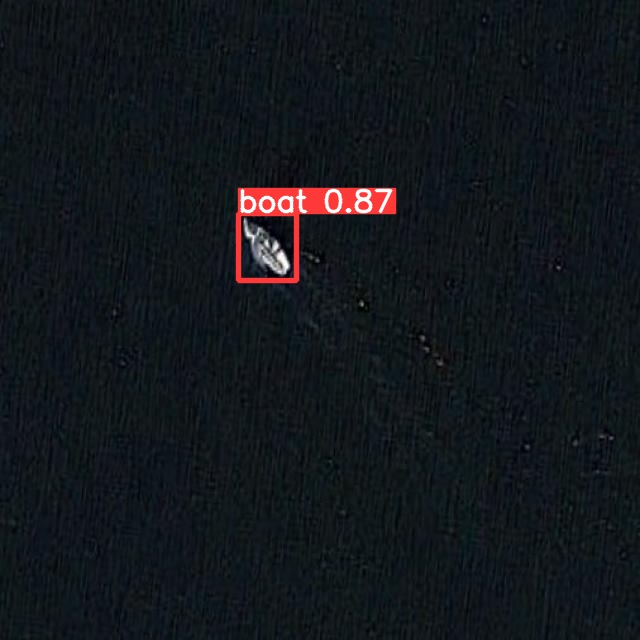

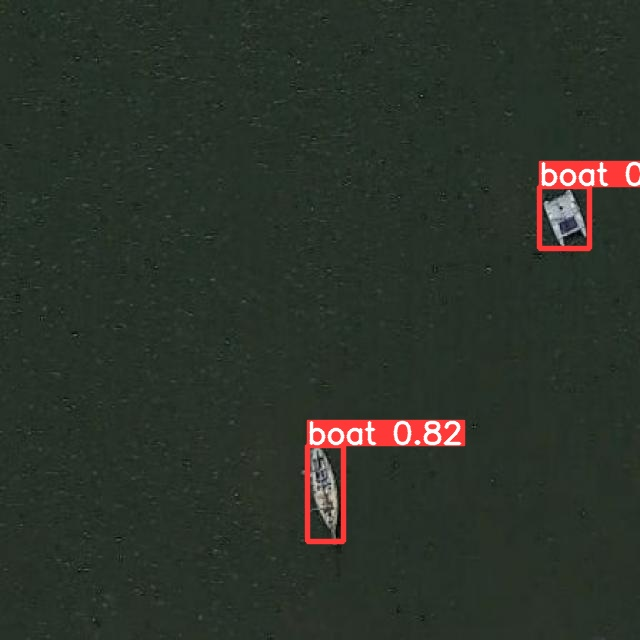

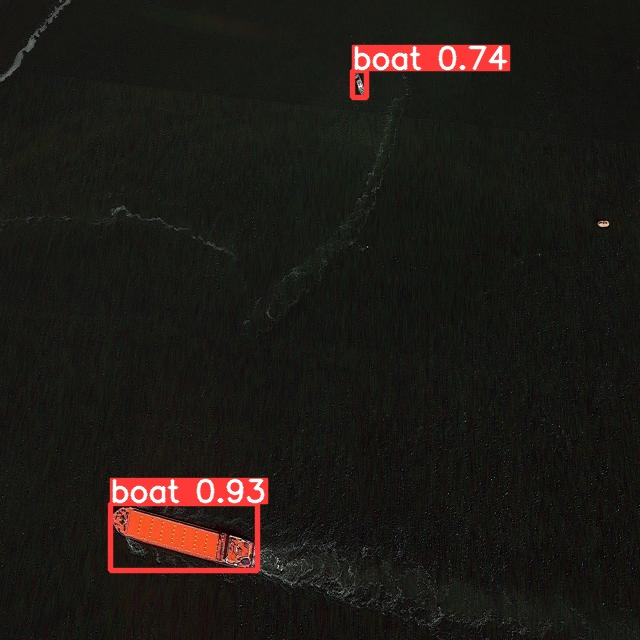

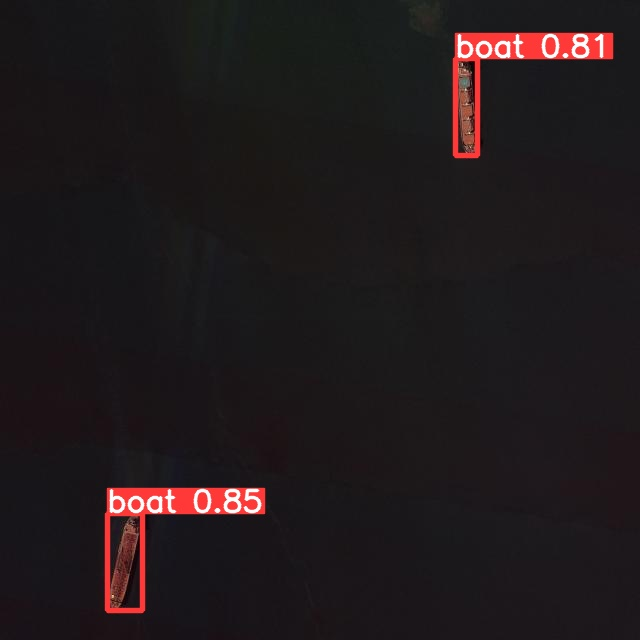

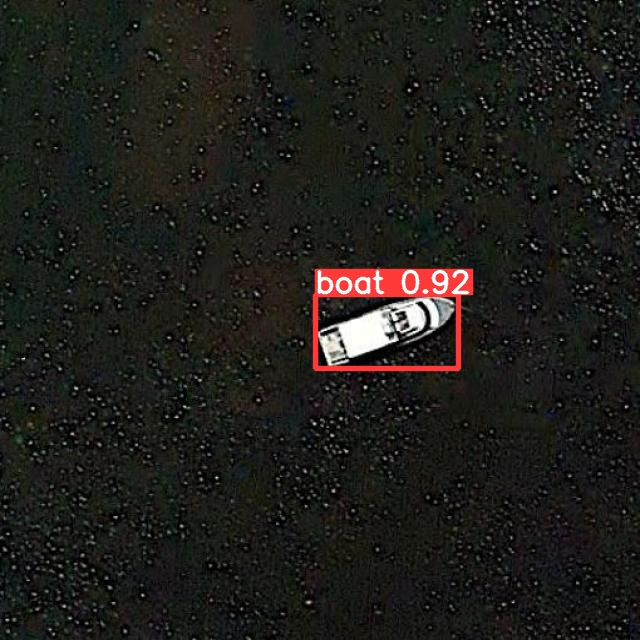

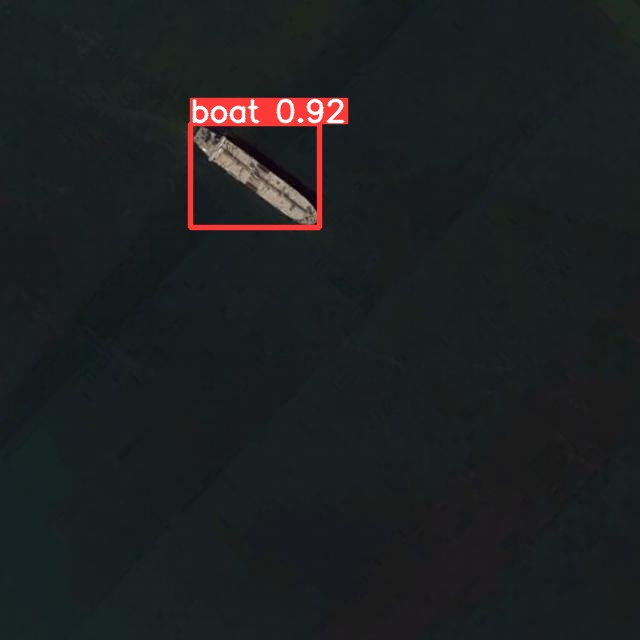

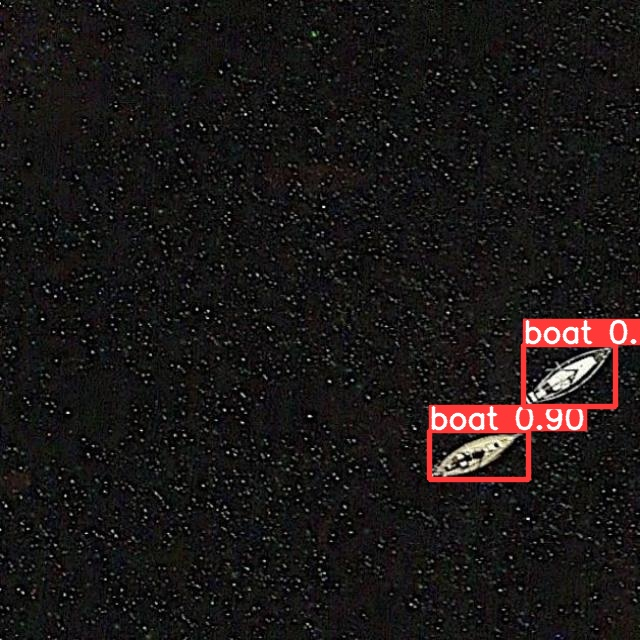

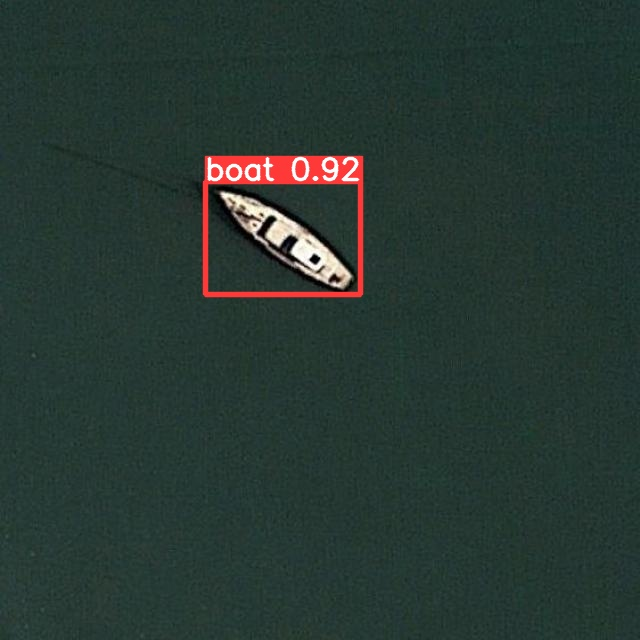

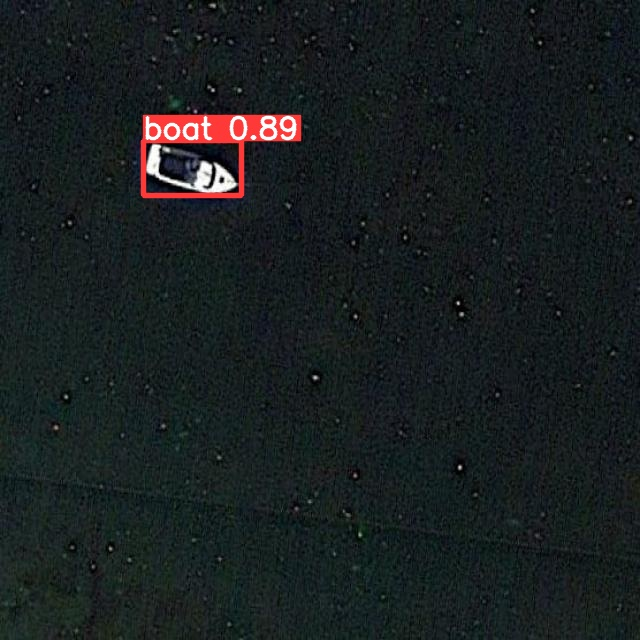

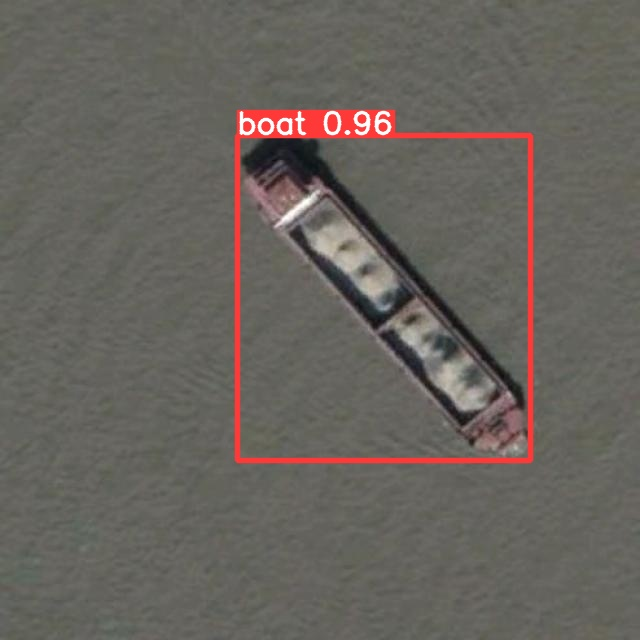

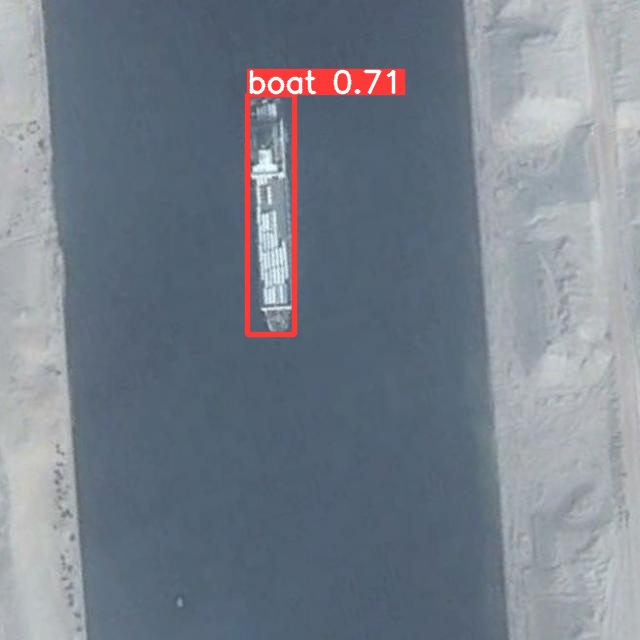

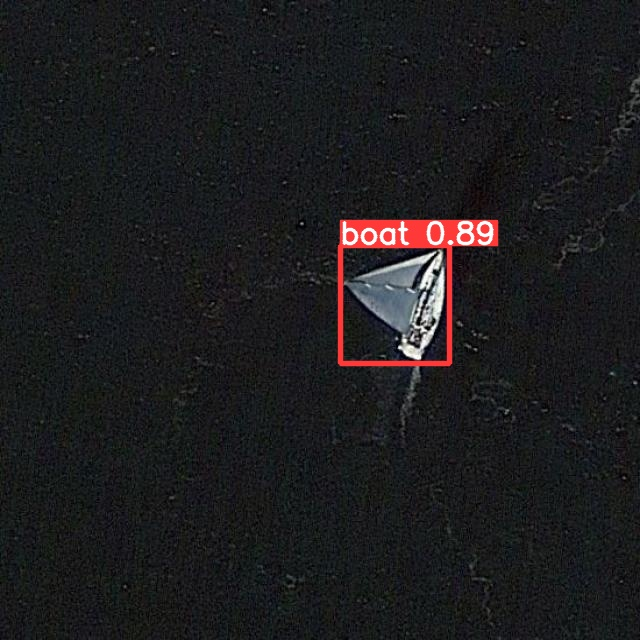

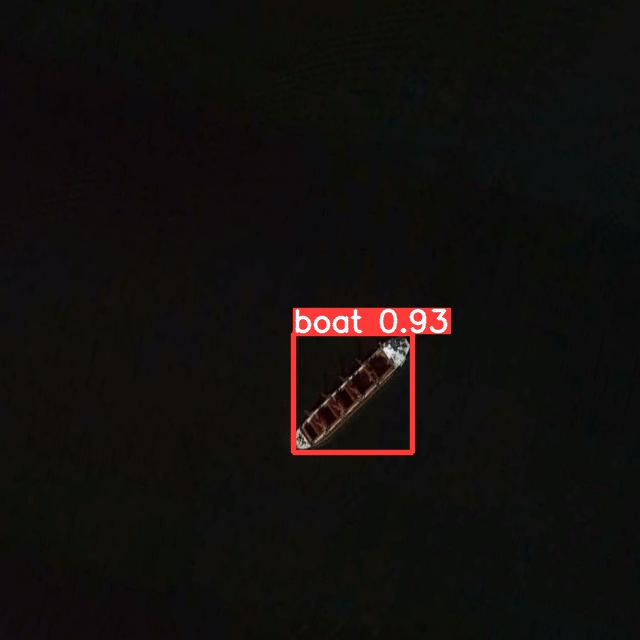

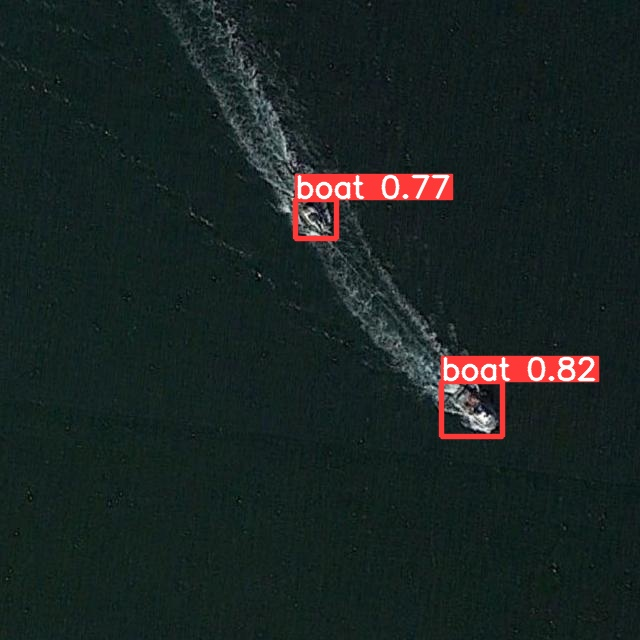

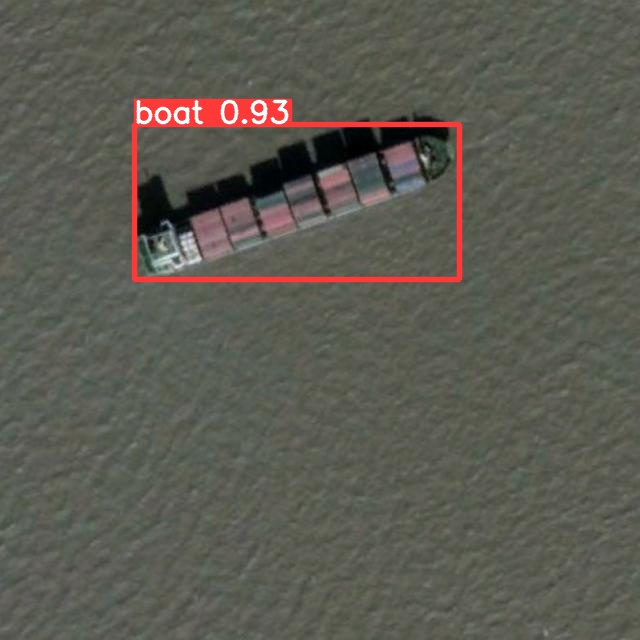

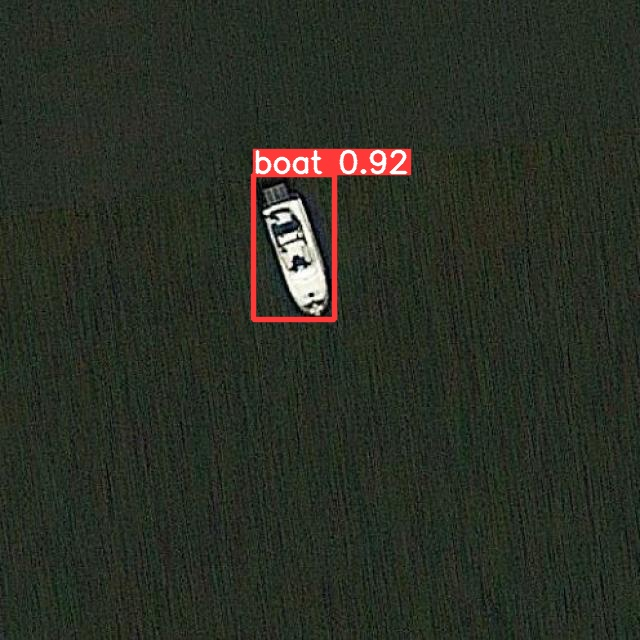

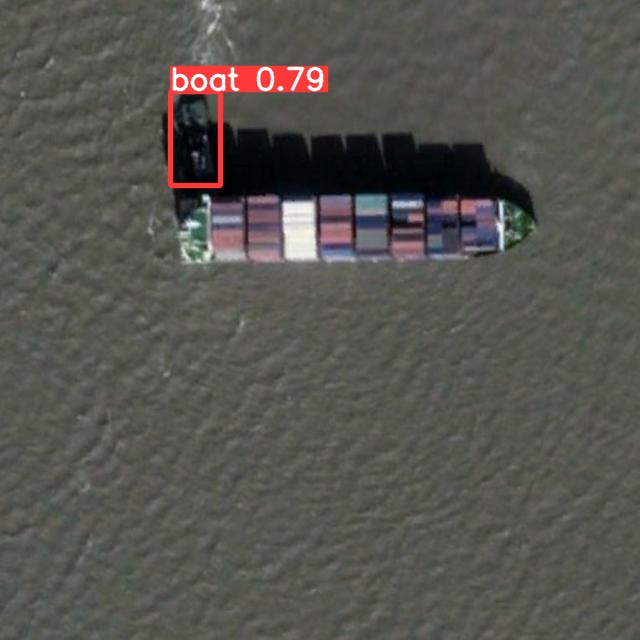

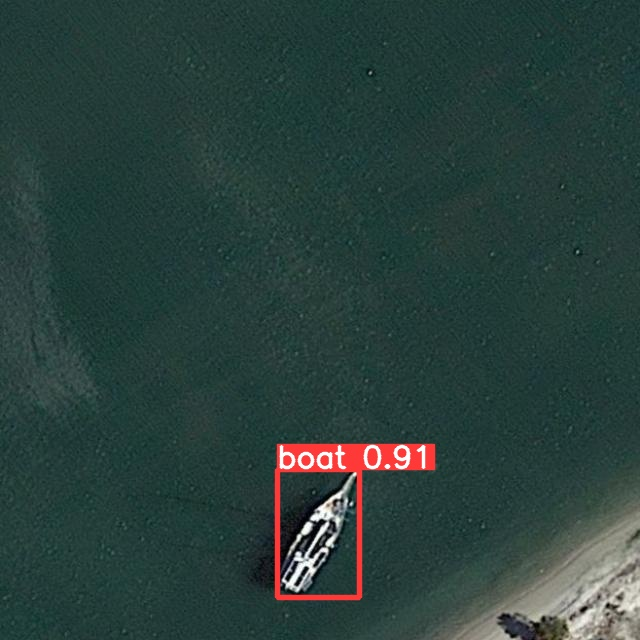

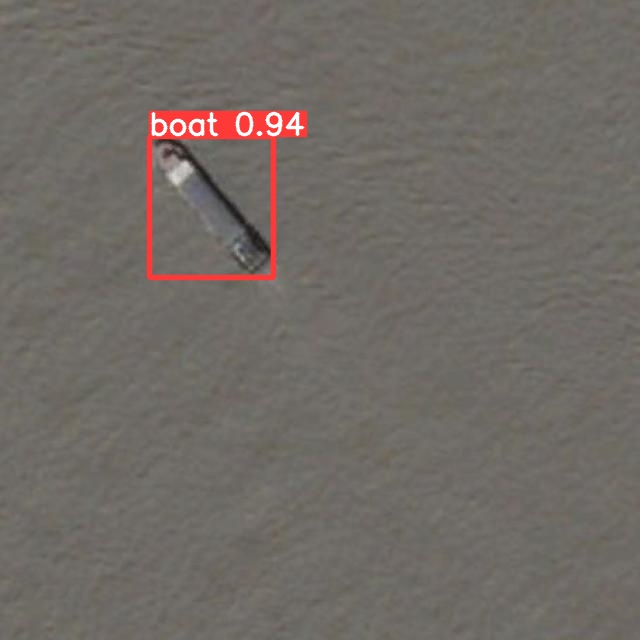

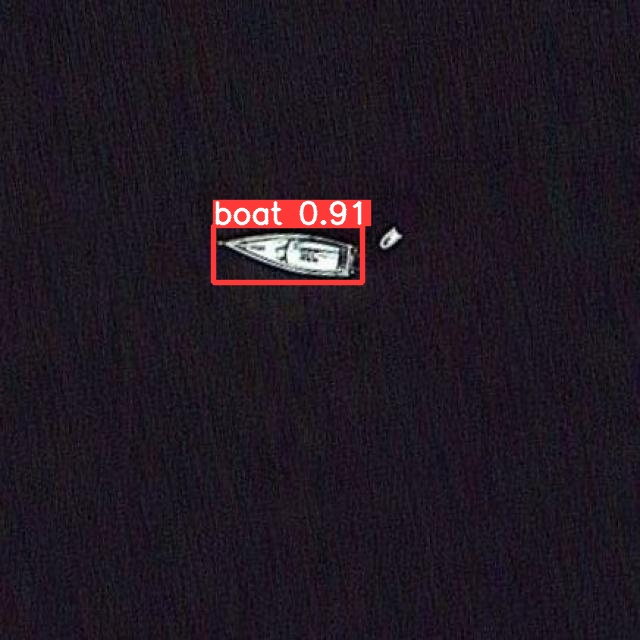

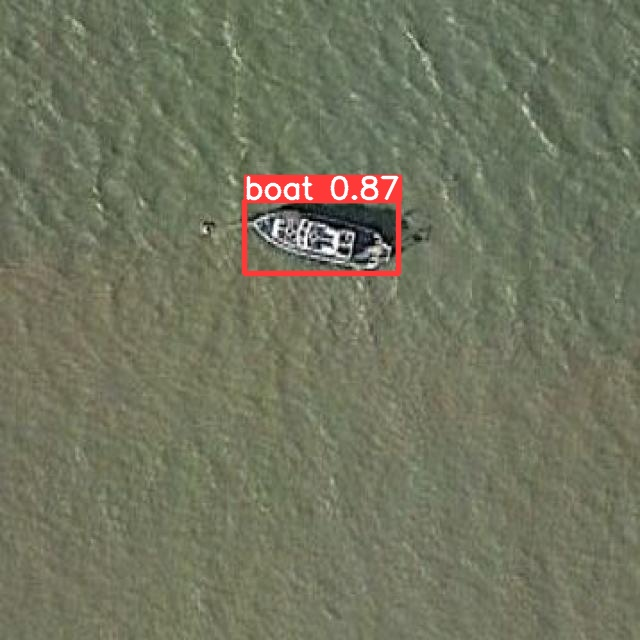

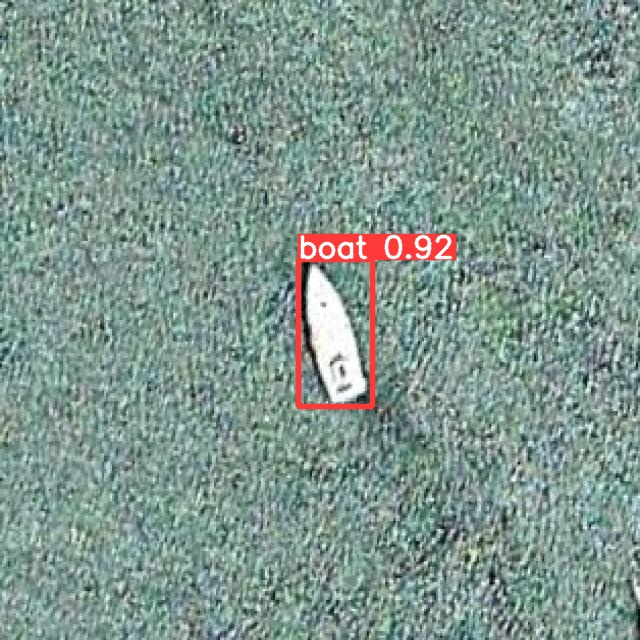

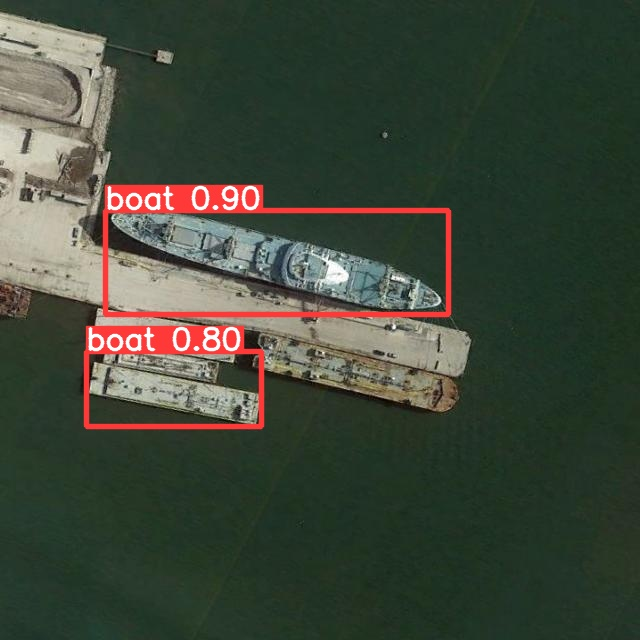

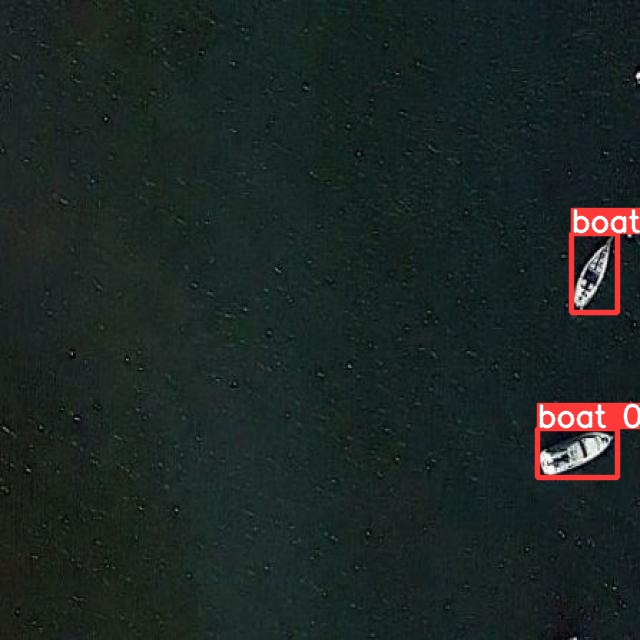

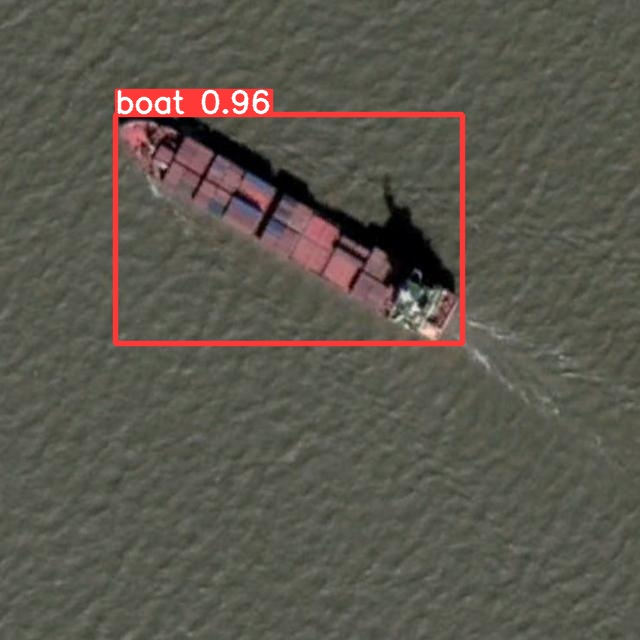

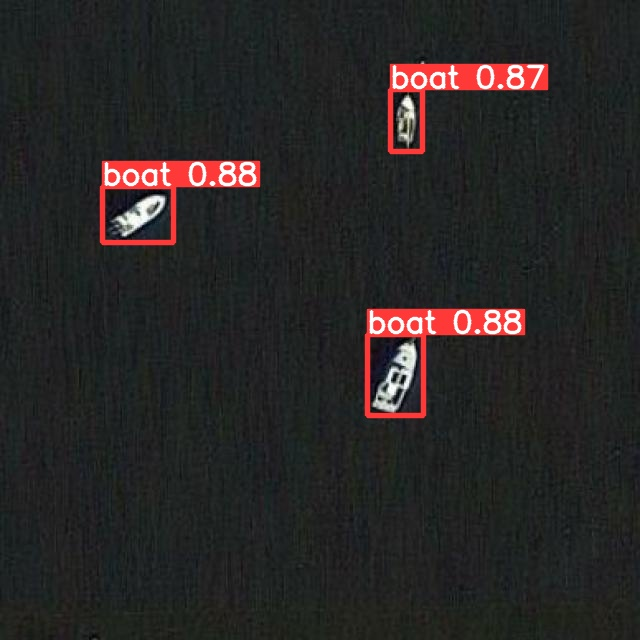

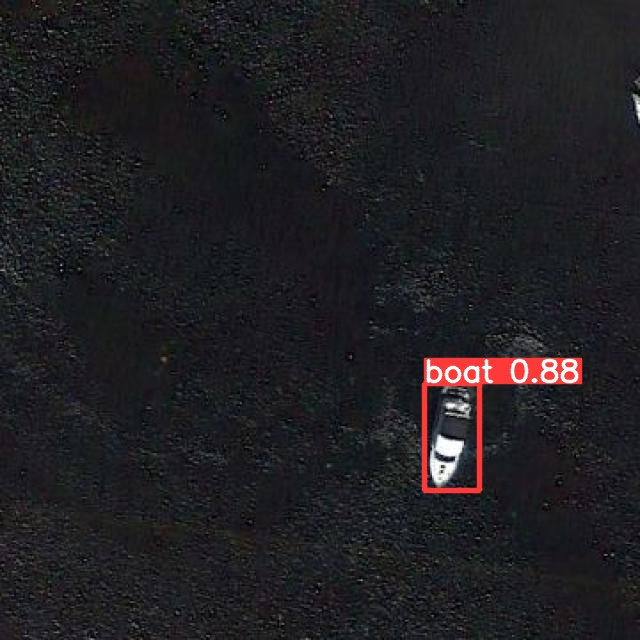

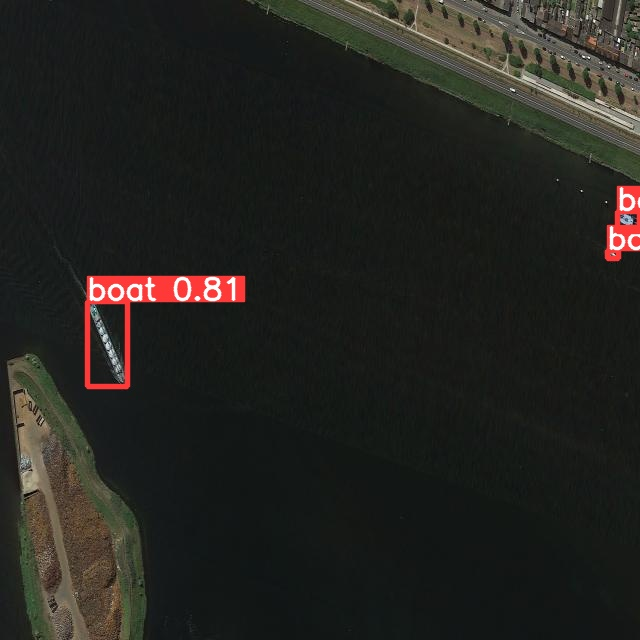

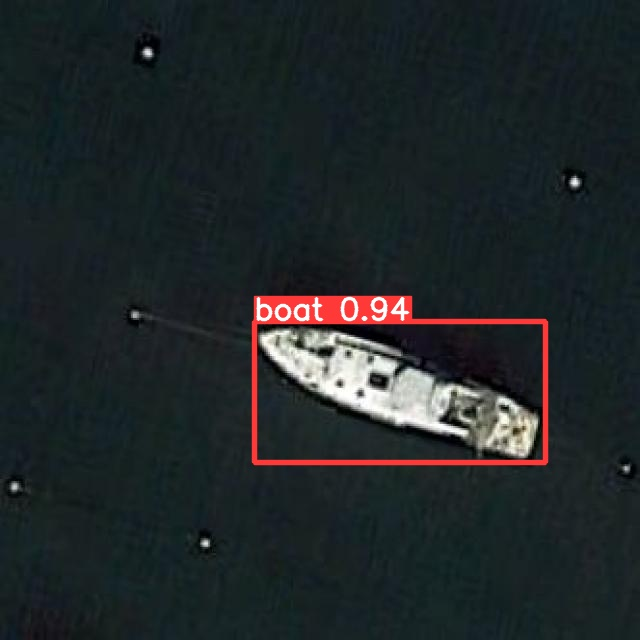

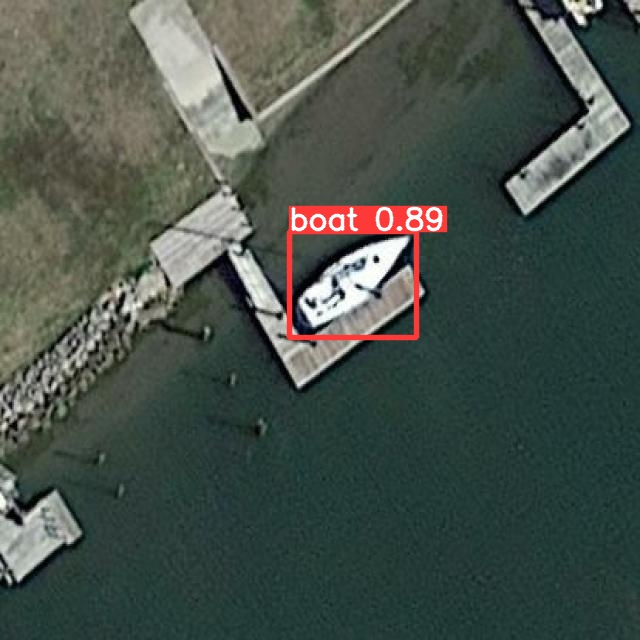

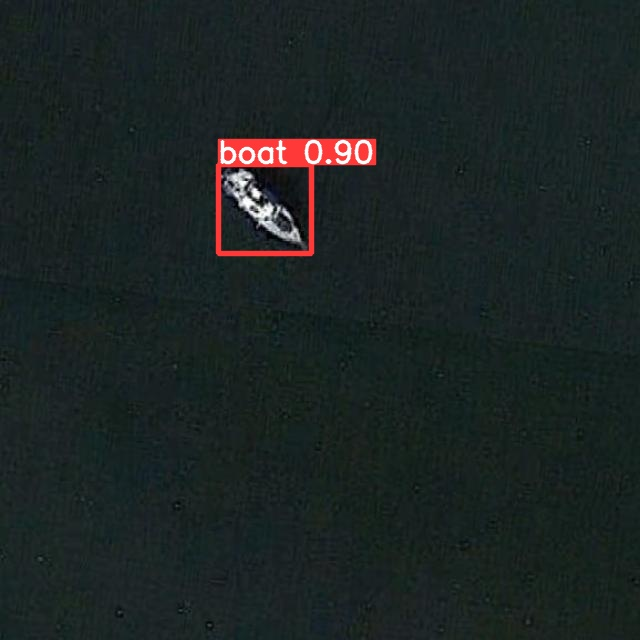

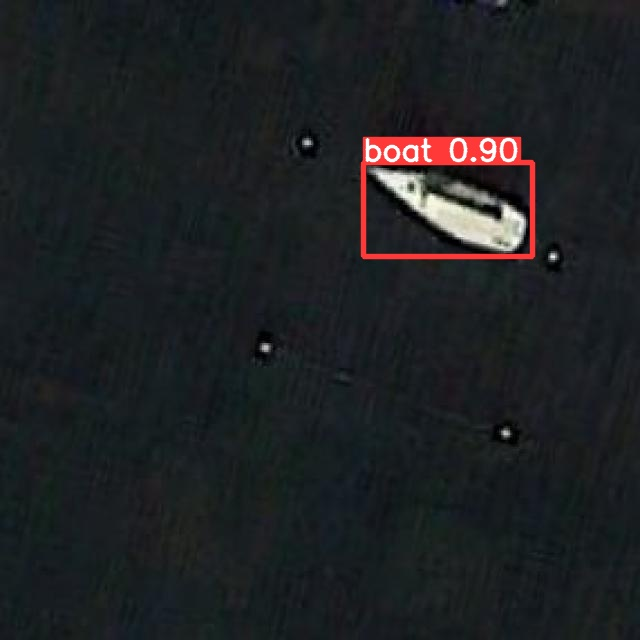

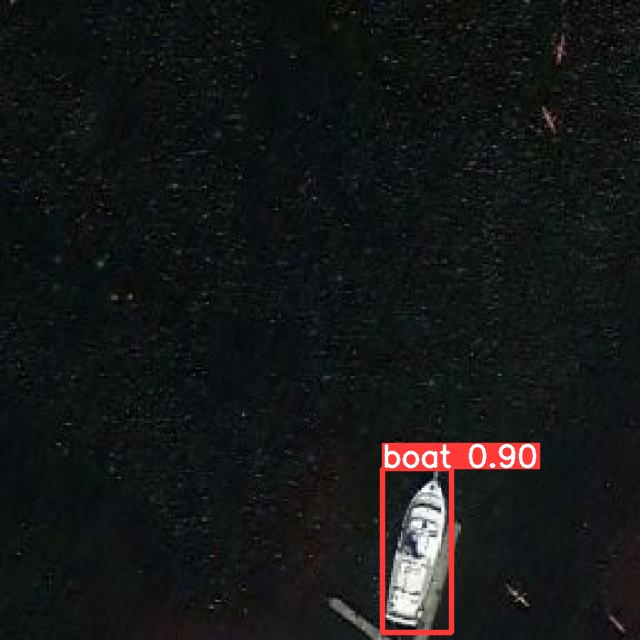

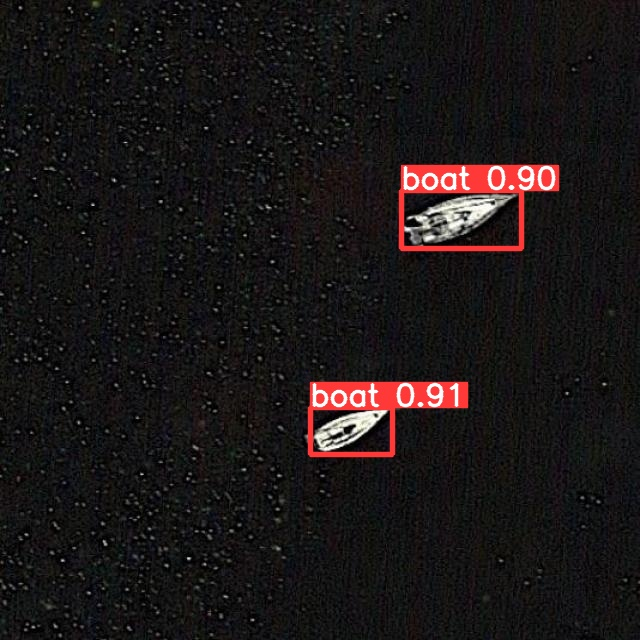

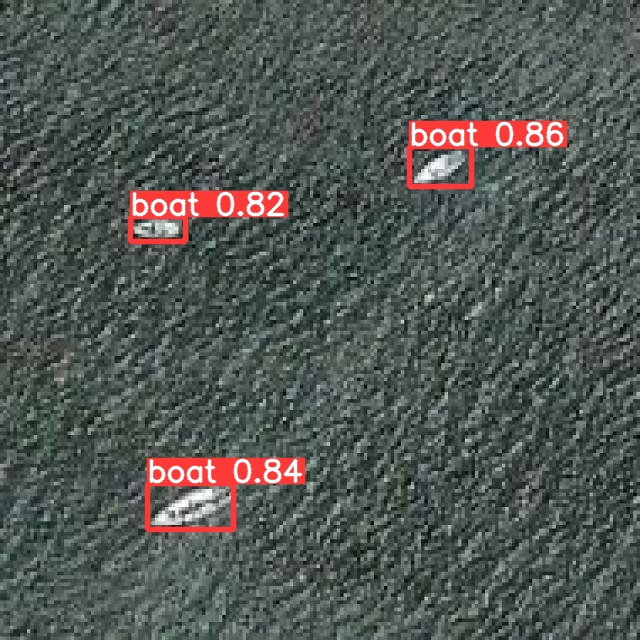

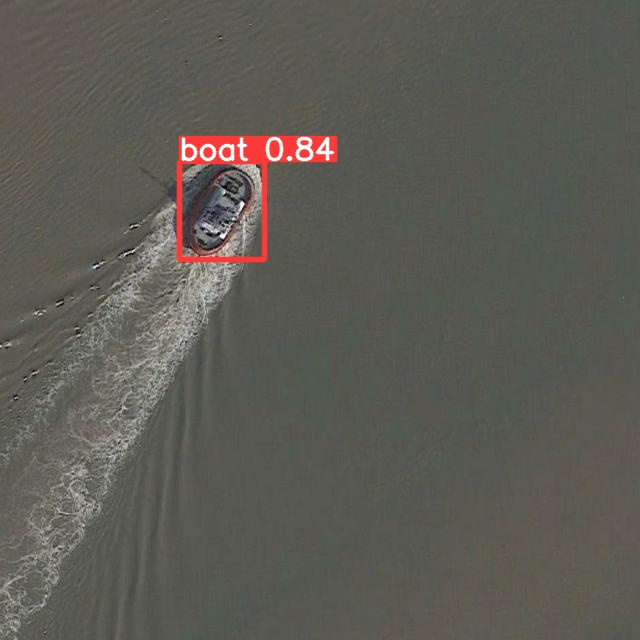

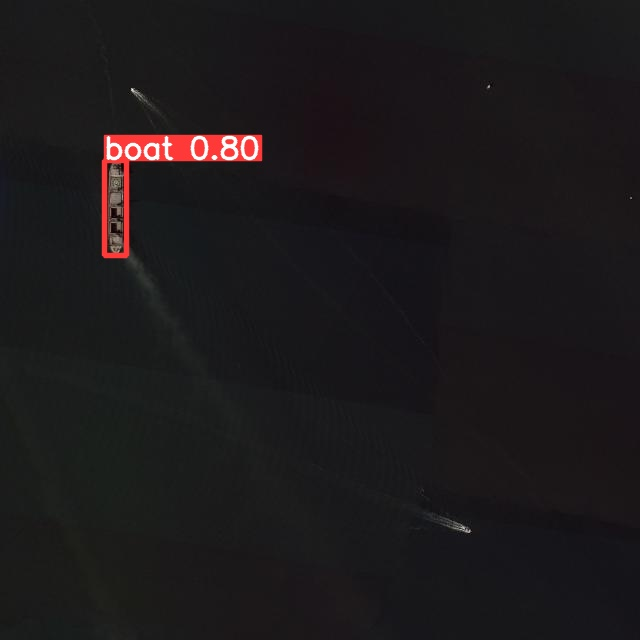

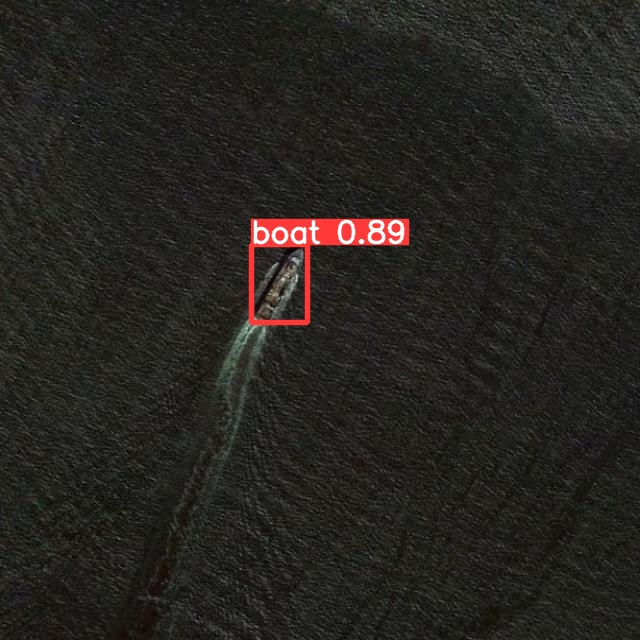

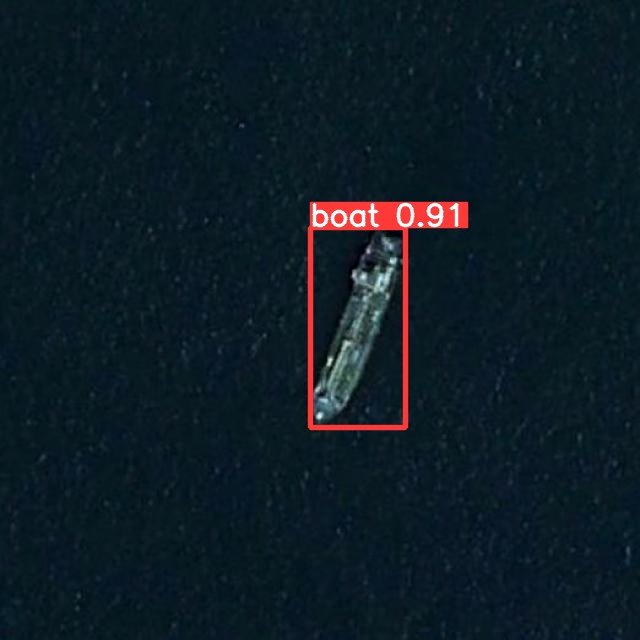

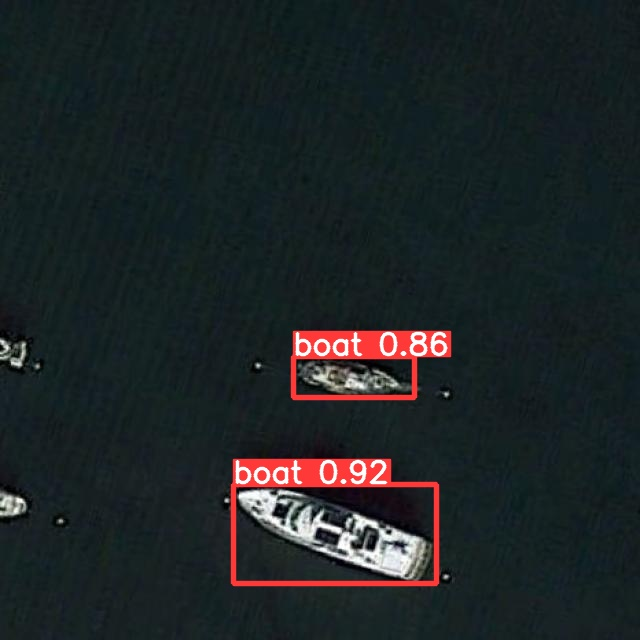

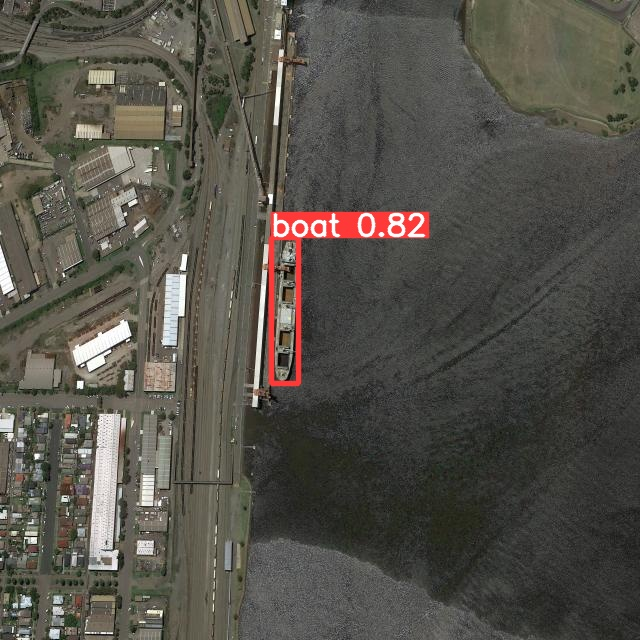

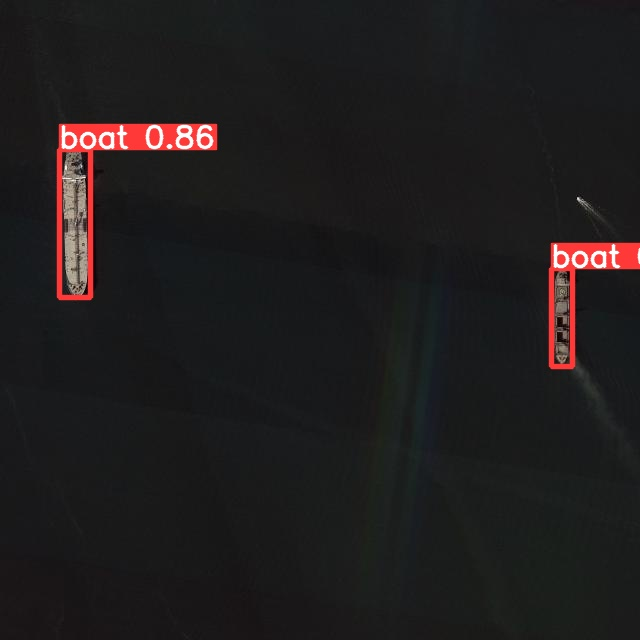

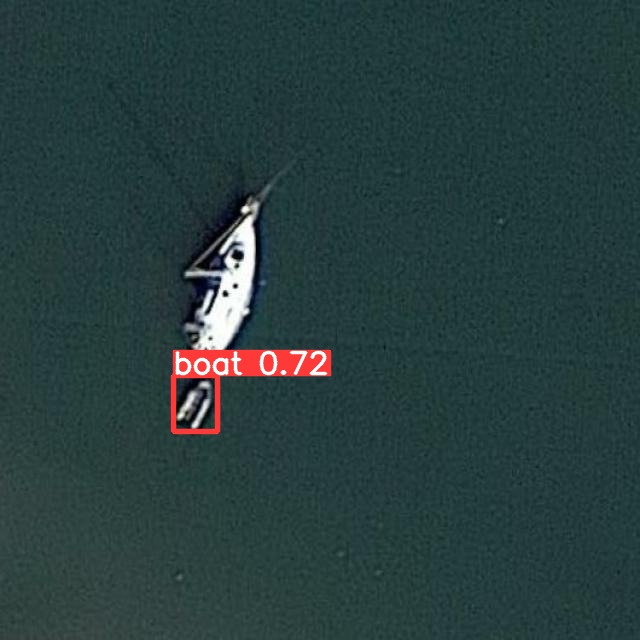

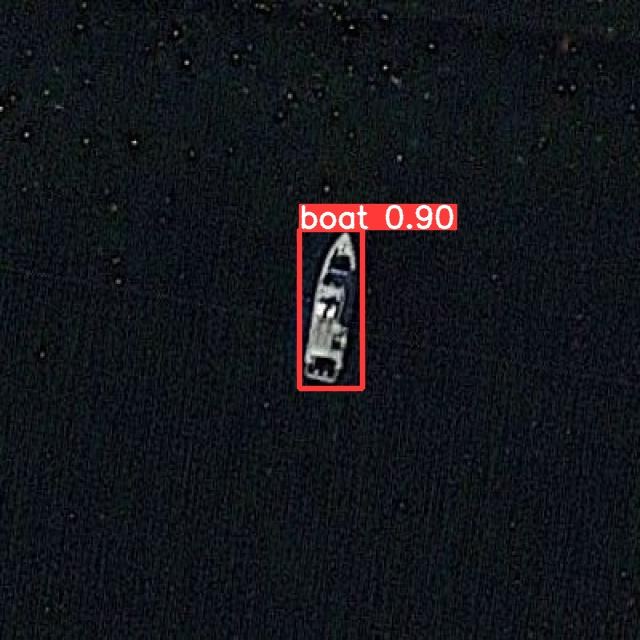

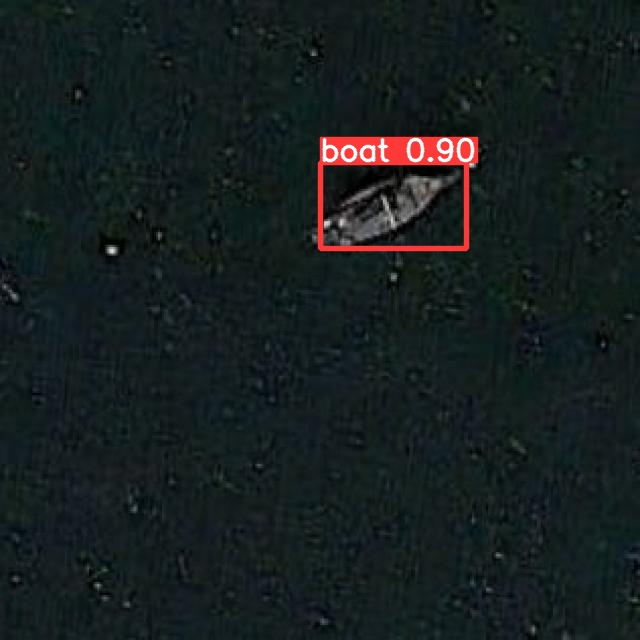

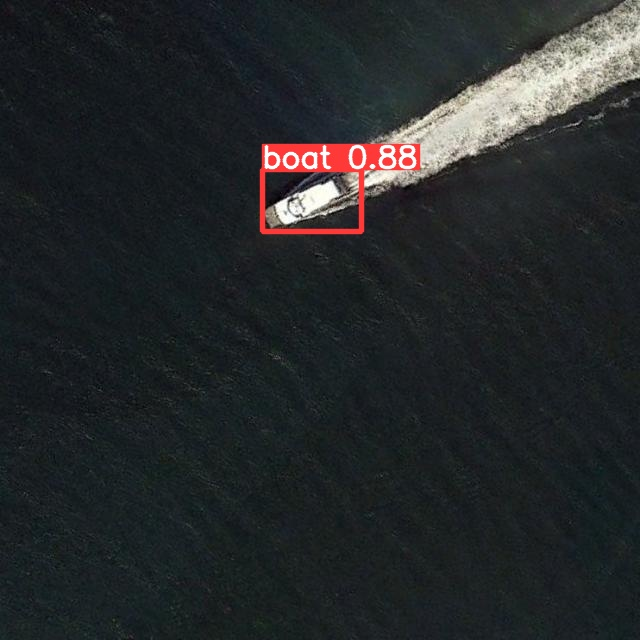

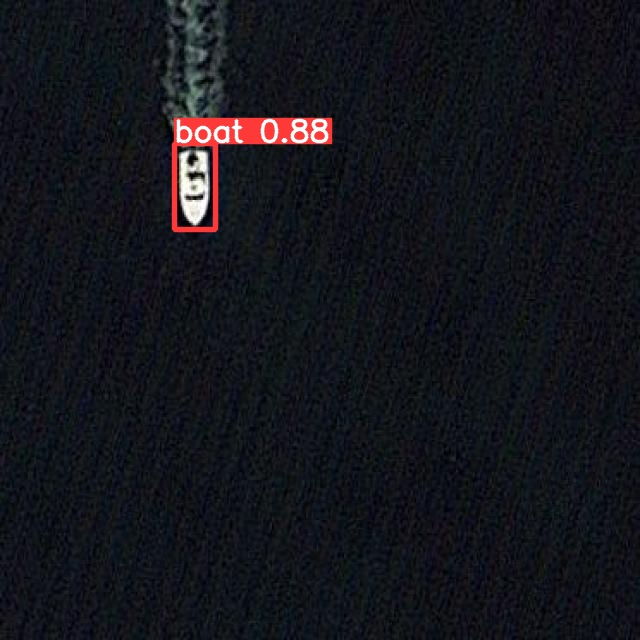

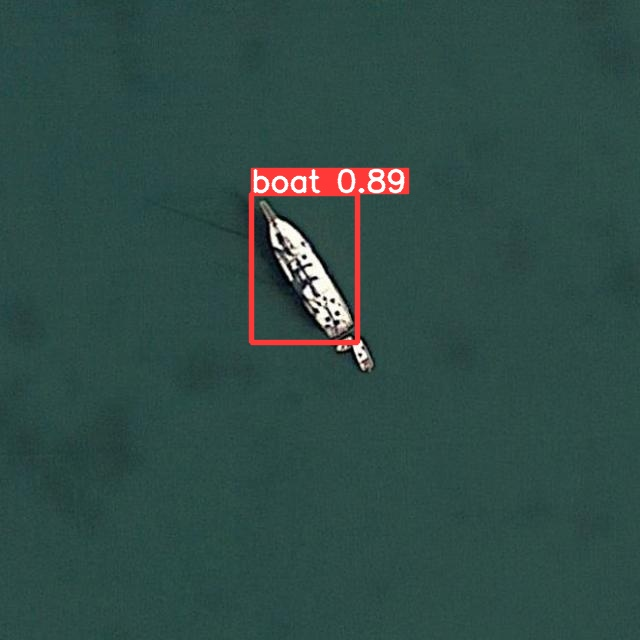

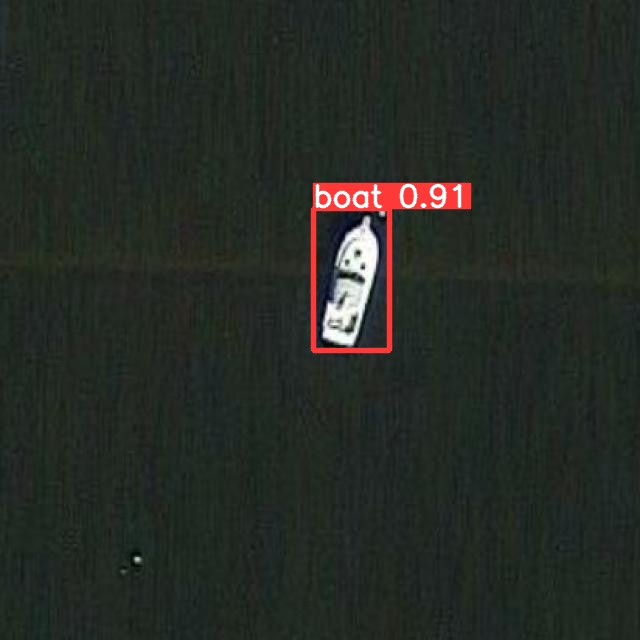

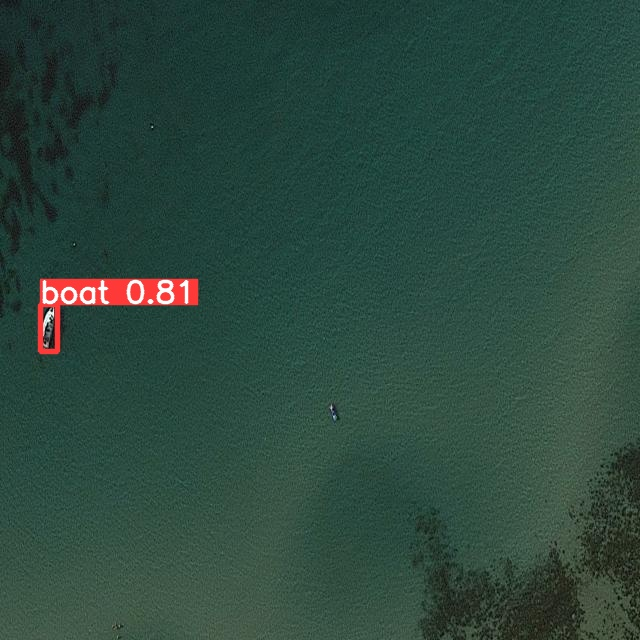

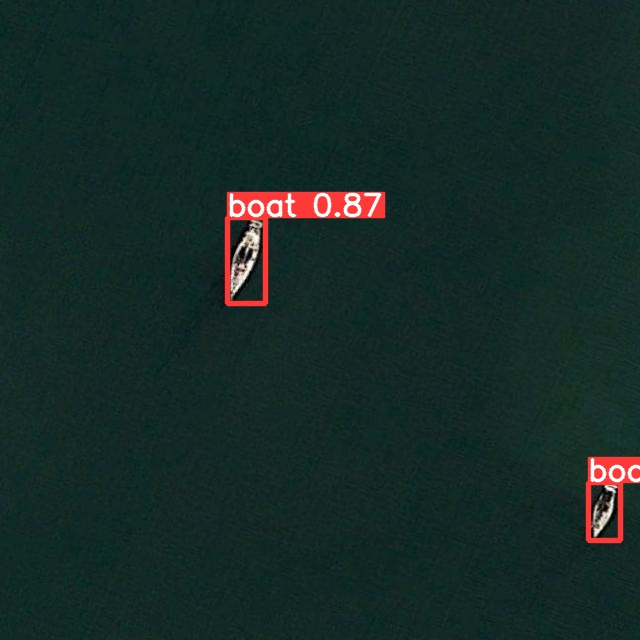

In [20]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg'):
      display(Image(filename=image_path, width=600))
      print("\n")